# Project of GBA 6430 - Fake Job Posting Prediction

#### - Phoebe Tran, Sonja Chill



## Milestone 1 : Project Proposal
***Objectives:***

Our project use the Real / Fake Job Posting Prediction to help applicants to identify and avoid job posting fraud.

- Identify key traits/features which are fraudulent in nature.

- Use Classification models(Logistic Regression and Random Forest) and NLP.

- Identify some interesting insights from the dataset.


***Dataset:***

URL:https://gba6430-schill.s3.amazonaws.com/project/job_postings.csv


### Import and test libraries

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
2,application_1659594020371_0003,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

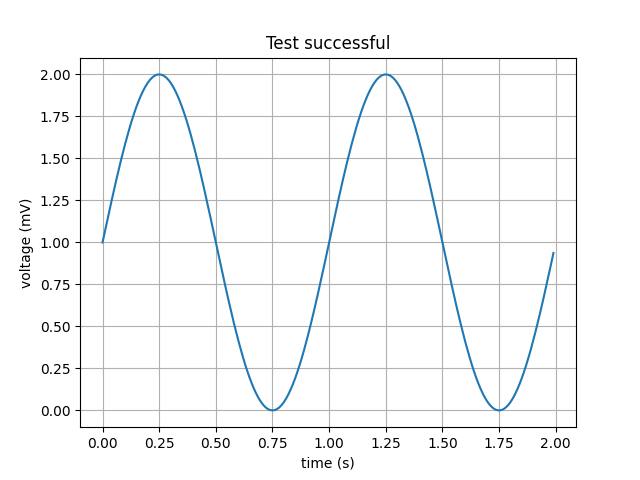

In [1]:
import pyspark.pandas as ps
ps.set_option('plotting.backend', 'matplotlib')
import pyspark.sql as sql
import pyspark.sql.functions as F
import pyspark.ml.feature as feat

#import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#from sklearn.metrics import roc_curve

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline
from pyspark.ml.feature import ChiSqSelector, CountVectorizer,StringIndexer,RegexTokenizer,StopWordsRemover,StandardScaler,SQLTransformer,Imputer,IDF,VectorAssembler
from pyspark.sql.functions import concat,col,udf,regexp_replace,isnull,trim,lower,explode,array,lit
from pyspark.sql.types import StringType,IntegerType
StopWordsRemover.loadDefaultStopWords('english')
import pyspark.ml.classification as cl
import pyspark.ml.evaluation as ev
import pyspark.ml.regression as rg
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.evaluation import RegressionEvaluator
import pyspark.ml.tuning as tune
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
import pyspark.ml.stat as st

#from pyspark.ml.classification import NaiveBayes, RandomForestClassifier, LogisticRegression, DecisionTreeClassifier, GBTClassifier
#from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
t = np.arange(0.0, 2.0, 0.01)
s = 1 + np.sin(2 * np.pi * t)
fig, ax = plt.subplots()
ax.plot(t, s)
ax.set(xlabel='time (s)', ylabel='voltage (mV)', title='Test successful')
ax.grid()
plt.show()
%matplot plt

In [2]:
# bar charts for categorical columns
def barchart(data, coln, bi):
    plt.figure(figsize=(24, 4))
    barc=data[coln][data['fraudulent'] == bi].value_counts().sort_values(ascending=False).iloc[:5].sort_values(ascending=True).plot.barh()
    plt.title('Top 5 {} Postings of "{}"'.format('Real' if bi==0 else 'Fake', coln.upper()))
    plt.tight_layout()
    return(plt)

# bar charts to compare real vs. fake job postings
def barvs(data,coln):
    f0=data[coln][data['fraudulent']== 0].value_counts().sort_values(ascending=False).iloc[:3].sort_values(ascending=True)
    f1=data[coln][data['fraudulent']== 1].value_counts().sort_values(ascending=False).iloc[:3].sort_values(ascending=True)
    fig,axj=plt.subplots(nrows=2,ncols=1) 
    axes = axj.flatten() 
    axes[0].barh(f0.index.to_numpy(),f0.to_numpy())
    axes[0].set_xlabel('Real')
    axes[1].barh(f1.index.to_numpy(),f1.to_numpy())
    axes[1].set_xlabel('Fake')
    plt.suptitle(       'Top 3 Postings of {}'.format(coln.upper()))
    plt.tight_layout()
    return(plt)

# pie charts to compare real vs. fake job postings
def pievs(data,n):
    f0=data['fraudulent'][data[n] == 0].value_counts()
    f1=data['fraudulent'][data[n] == 1].value_counts()
    fig,axj=plt.subplots(nrows=1,ncols=2) 
    axes = axj.flatten() 
    axes[0].pie(x=f0.to_numpy(),labels=["real", "fake"], autopct = '%3.2f%%')
    axes[0].set_xlabel('{} = NO'.format(n.title()))
    axes[1].pie(x=f1.to_numpy(),labels=["real", "fake"], autopct = '%3.2f%%')
    axes[1].set_xlabel('{} = YES'.format(n.title()))
    plt.suptitle('The Distribution of {}'.format(n.title()))
    plt.tight_layout()
    return(plt)

# Histograms for numerical columns comparing real vs. fake postings
def hstvs(data,coln):
    f0=data[coln][data['fraudulent']== 0]
    f1=data[coln][data['fraudulent']== 1]
    fig,axj=plt.subplots(nrows=1,ncols=2) 
    axes = axj.flatten() 
    axes[0].hist(f0)
    axes[0].set_xlabel('Real')
    axes[1].hist(f1)
    axes[1].set_xlabel('Fake')
    plt.suptitle('Histogram of {}'.format(coln))
    return(plt)

# Scatter plots for numerical columns
def scatterplot(data,a,b):
    data.plot.scatter(a, b)
    #plt.title( 'Scatter: {} vs. {}'.format(a, b))
    return(plt)

def addToRow(row, key, value): 
    dic = row.asDict()
    dic[key] = value
    return sql.Row(**dic)

# self-defined metrics which can show the missed
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="fraudulent", rawPredictionCol="prediction", metricName="areaUnderROC")
def metrics(result):
    TP = result.filter(result['prediction'] == 1).filter(result['fraudulent'] == 1).count()
    FN = result.filter(result['prediction'] == 0).filter(result['fraudulent'] == 1).count()
    TN = result.filter(result['prediction'] == 0).filter(result['fraudulent'] == 0).count()
    FP = result.filter(result['prediction'] == 1).filter(result['fraudulent'] == 0).count()
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1 =(2*precision*recall)/(precision+recall)
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    aur = evaluator.evaluate(result)
    print("precision:", precision)
    print("recall:", recall)
    print("F1:", F1)
    print("accuracy:", accuracy)
    missed=FN/(FN+TN)
    print('missed:', missed)
    print ("AUR:", aur)
    return(precision,recall,F1,accuracy,missed,aur)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Milestone 2 : Data Preprocessing

***Data Preprocessing Plan:***

1.  The project objective, methods, and explanation of our dataset, including independent/dependent variables and column descriptions.

2. Duplicates and missing values

3. descriptive statistics

4. Visualization. 
 - numeric columns: histogram
 - categorical columns: bar/barh/pie
 - any two related numeric columns: scatter
 
5. Outlier

6. Rerun descriptive statistics and redraw plots if needed

### Data loading and description

***Variables Definition***<br>

- `job_id`: Unique Job ID<br>
- `title`: The title of the job ad entry<br>
- `location`: Geographical location of the job ad<br>
- `department`: Corporate department (e.g. sales)<br>
- `salary_range`: Indicative salary range (e.g. $50,000-60,000)<br>
- `company_profile`: A brief company description<br>
- `description`: The details description of the job ad<br>
- `requirements`: Enlisted requirements for the job opening<br>
- `benefits`: Enlisted offered benefits by the employer<br>
- `telecommuting`: True for telecommuting positions<br>
- `has_company_logo`: True if company logo is present<br>
- `has_questions`: True if screening questions are present<br>
- `employment_type`: Full-type, Part-time, Contract, etc<br>
- `required_experience`: Executive, Entry level, Intern, etc<br>
- `required_education`: Doctorate, Master’s Degree, Bachelor, etc<br>
- `industry`: Automotive, IT, Health care, Real estate, etc<br>
- `function`: Consulting, Engineering, Research, Sales etc<br>
- `fraudulent`: target - Classification attribute

***Variables Grouping***<br>

There are 18 columns/variables in the original data.  The `fraudulent` is the Dependent Variable(DV).  For better management, we divide them into four group based on the feature-type(except `job_id`):<br>
- 1. bin_features(binary): `telecommuting`, `has_company_logo`, `has_questions`, `fraudulent`(Dependent Variable)<br>
- 2. text_features(long text) = `company_profile`, `description`, `requirements`, `benefits`<br>
- 3. complex_features(to be splitted) = `location`, `salary_range`
- 4. cat_features(normal categ): `title`,`department`, `employment_type`, `required_experience`, `required_education`, `industry`, `function`<br>

In [5]:
bin_features = ['telecommuting', 'has_company_logo', 'has_questions'] # except DV
text_features = ['company_profile', 'description', 'requirements', 'benefits']
complex_features = ['location', 'salary_range']
cat_features = ['title', 'department', 'employment_type', 'required_experience', 
                'required_education', 'industry', 'function']
raw = ps.read_csv('s3://gba6430-schill/project/job_postings.csv')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Handling duplicates

- Exact duplicates

In [4]:
# do we have any rows that are duplicated?
print(raw.shape, raw.to_spark().distinct().count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(17880, 18) 17880

- Duplicates where only ID differs

In [5]:
# count of rows
no_ids = (
    raw[[col for col in raw.columns if col != 'Id']]
)

no_ids.shape[0], no_ids.to_spark().distinct().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(17880, 17880)

***Conclusion: No duplicated rows***

### Handling missing observations

- Missing observations per row

In [6]:
#count the number of missing values in each row
naPerRow = raw.set_index('job_id').isna().sum(axis=1)
naPerRow.sort_values(ascending=False).head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

job_id
145      11
1879     11
2316     11
3034     11
16628    11
dtype: int64

The most NULL values a single raw has is 11.  There are 18 variables.  11/18 is accetable in our model.  To indentify the Fraudulency, we won't drop any raw.  Instead, we will refill them with different values when we explore the features.

- Missing observations per column

In [15]:
# count percentage of missing values in each column
raw.set_index('job_id').isna().sum(axis=0)/raw.shape[0]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

fraudulent             0.000000
telecommuting          0.000000
has_company_logo       0.000000
has_questions          0.000000
location               0.019351
salary_range           0.849049
employment_type        0.194128
required_education     0.453300
department             0.646253
title                  0.000000
company_profile        0.185011
description            0.000056
requirements           0.151063
benefits               0.404474
required_experience    0.394295
industry               0.274217
function               0.361074
dtype: float64

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

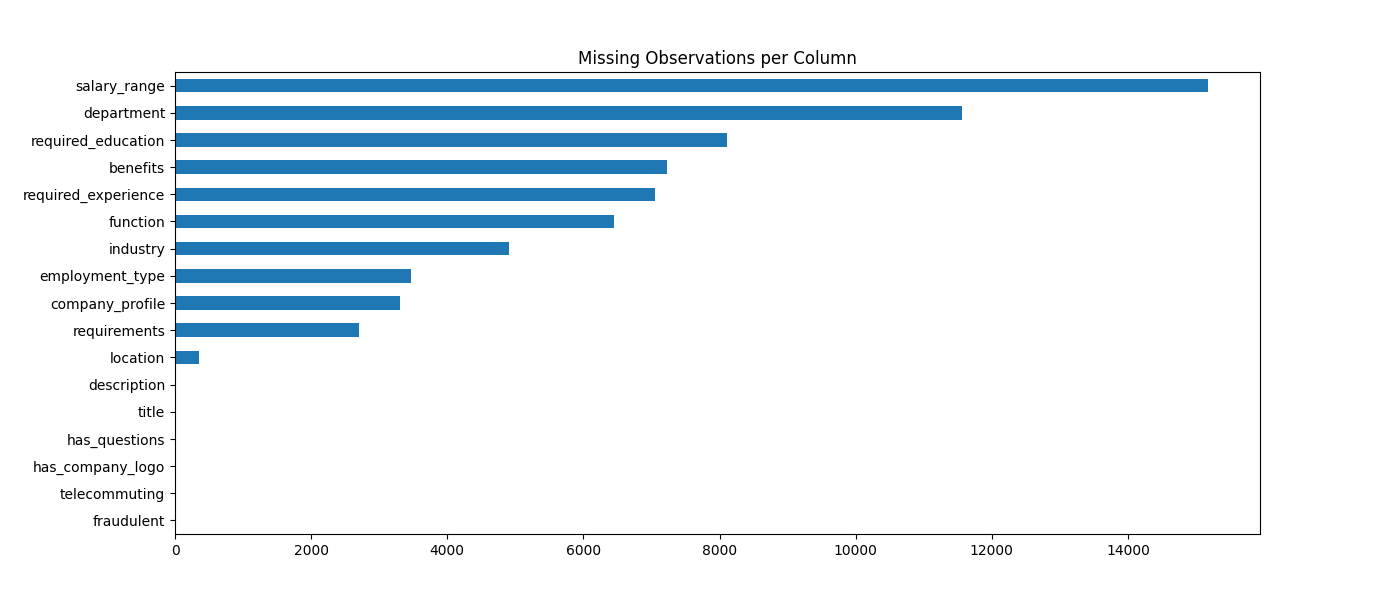

In [16]:
plt.clf()
plt.figure(figsize=(14, 6))
raw.set_index('job_id').isna().sum(axis=0).sort_values(ascending=True).plot.barh()
plt.title('Missing Observations per Column')
%matplot plt

84.90% of `salary_range` are missing values,  64.62% of `department` are missing values.  However,miss values have special meanings in the fraudulency prediction, we won't drop any column.

### Target/Dependent Variable

In [3]:
data = ps.read_csv('s3://gba6430-schill/project/job_postings.csv')
data['fraudulent'].value_counts()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0    17014
1      866
Name: fraudulent, dtype: int64

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

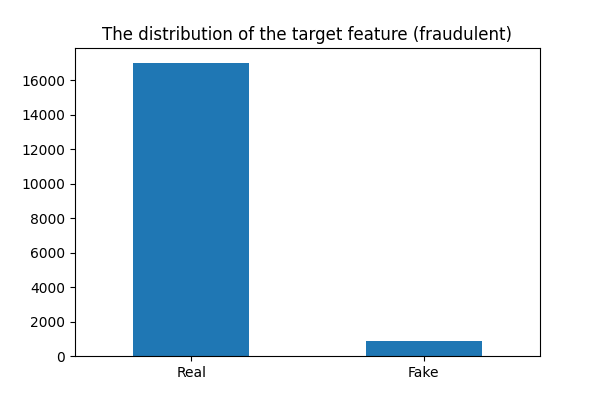

In [18]:
plt.clf()
plt.figure(figsize=(6, 4))
data['fraudulent'].value_counts().plot.bar()
plt.xticks(ticks=[0,1], labels=['Real','Fake'],rotation=360)
plt.title('The distribution of the target feature (fraudulent)')
%matplot plt

Class distributions are 95% for 0 (Real Post) and 5% for 1 (Fake Post). They are not balanced, so we have to use
oversampling/undersampling and calculate not-only-accuracy metrics (ROC AUC,f1 etc.) to estimate our models in
the future

### Binary features

In [86]:
datab = data[['fraudulent', 'telecommuting', 'has_company_logo', 'has_questions']]
datab[bin_features].head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   telecommuting  has_company_logo  has_questions
0              0                 1              0
1              0                 1              0
2              0                 1              0
3              0                 1              0
4              0                 1              1

In [54]:
datab['telecommuting'].value_counts()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0    17113
1      767
Name: telecommuting, dtype: int64

There are non-binary values in the binary columns.  We can refill them and miss values with 0. 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

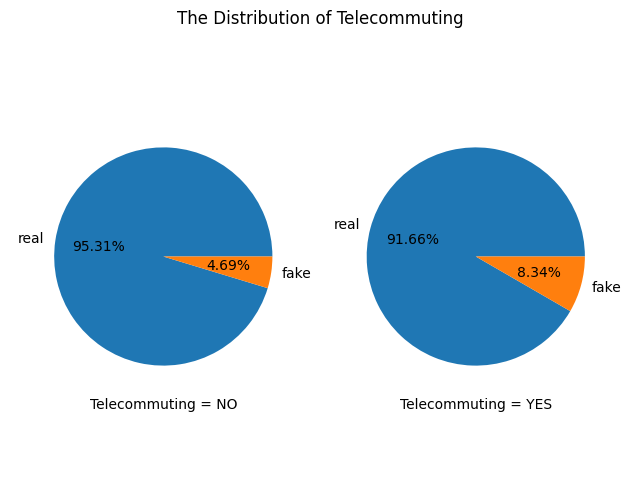

In [10]:
plt.clf()
pievs(datab,'telecommuting')
%matplot plt

More percent of fake posts use telecommuting.

In [22]:
datab['has_company_logo'].value_counts()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1    14220
0     3660
Name: has_company_logo, dtype: int64

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

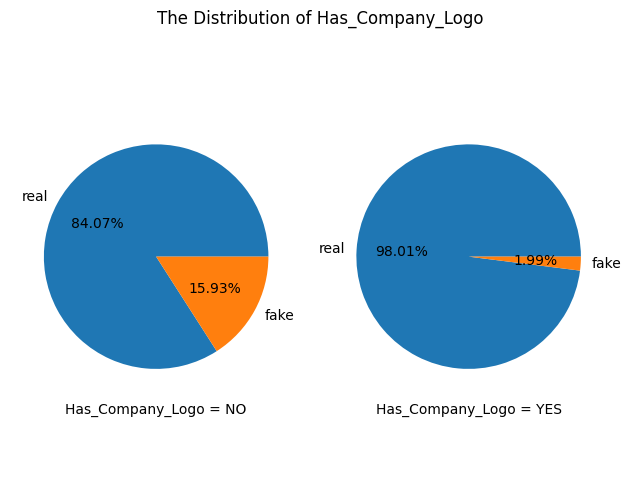

In [23]:
plt.clf()
pievs(datab,'has_company_logo')
%matplot plt

Less percent of fake posts have company-logos.

In [24]:
datab['has_questions'].value_counts()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0    9088
1    8792
Name: has_questions, dtype: int64

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

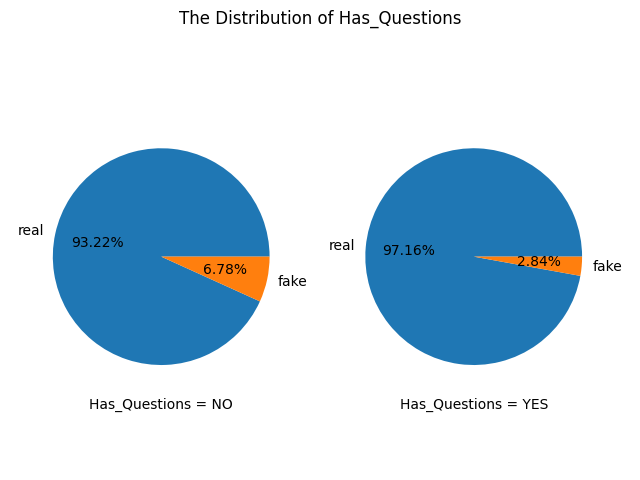

In [17]:
plt.clf()
pievs(datab,'has_questions')
%matplot plt

Less percent of fake posts have screening questions in the survey.

### Text features
- 1. Count the numbers of charaters for each text feature
- 2. Regroup text length (numeric) features
- 3. Combine all text features to one feature and drop original ones
- 4. Descriptive explore and visualize

In [6]:
datat=data[['job_id', 'fraudulent']+text_features]
datat[text_features].info()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 17880 entries, 0 to 17879
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   company_profile  14572 non-null  object
 1   description      17879 non-null  object
 2   requirements     15179 non-null  object
 3   benefits         10648 non-null  object
dtypes: object(4)

Base on the findings of Milestone 3, NLP is not as helpful as we expected.  So we are back here to generate more information from text features.  There are many miss values, so we can generate bool features to know whether the postings specified their information. If the text length is less than 10, we identified it as unspecified.

In [88]:
for c in text_features:
    datat['{}_specified'.format(c)] = datat[c].fillna(0)
    datat['{}_specified'.format(c)] = datat['{}_specified'.format(c)].map(
        lambda x : 0 if x == '0'  or len(x) < 10 else 1)
text_spec_features=['{}_specified'.format(c) for c in text_features]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [89]:
data = ps.merge(data, datat[text_spec_features+['job_id']], on='job_id', how='left')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [90]:
datat[text_features]=datat[text_features].fillna("")
# generate new numeric columns by the length of each text feature
datat['company_profile_len']=datat['company_profile'].str.len()
datat['description_len']=datat['description'].str.len() 
datat['requirements_len']=datat['requirements'].str.len() 
datat['benefits_len']=datat['benefits'].str.len() 
#group text length features
textlen_features = ['company_profile_len', 'description_len', 'requirements_len','benefits_len']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [91]:
data = ps.merge(data, datat[textlen_features+['job_id']], on='job_id', how='left')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [95]:
datat[textlen_features+text_spec_features].head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   company_profile_len  description_len  requirements_len  benefits_len  company_profile_specified  description_specified  requirements_specified  benefits_specified
0                  854              881               833             0                          1                      1                       1                   0
1                 1235             2013              1389          1265                          1                      1                       1                   1
2                  858              348              1336             0                          1                      1                       1                   0
3                  594             2557              1402           766                          1                      1                       1                   1
4                 1585             1410               743            21                          1                      1                       1                   1

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

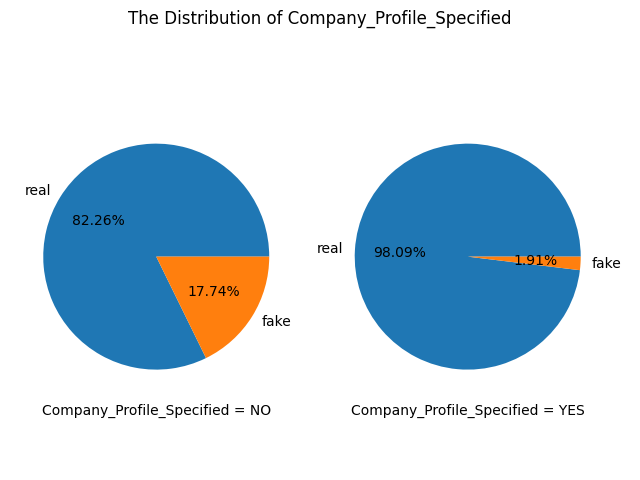

In [96]:
plt.clf()
pievs(datat,text_spec_features[0])
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

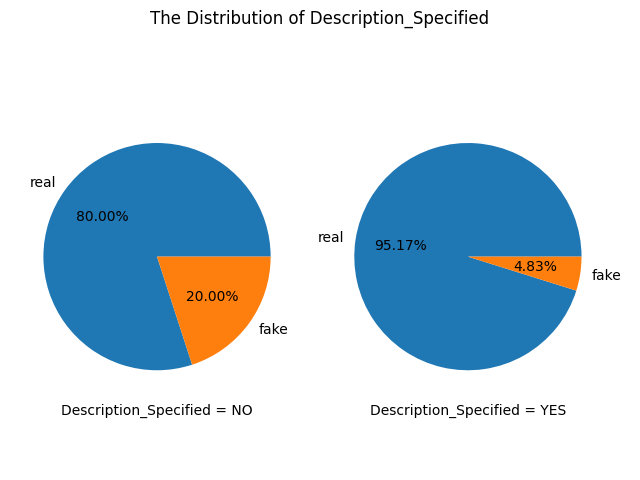

In [40]:
plt.clf()
pievs(datat,text_spec_features[1])
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

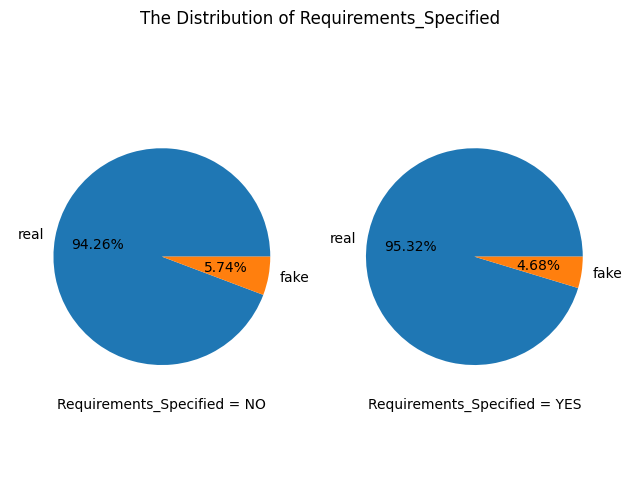

In [41]:
plt.clf()
pievs(datat,text_spec_features[2])
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

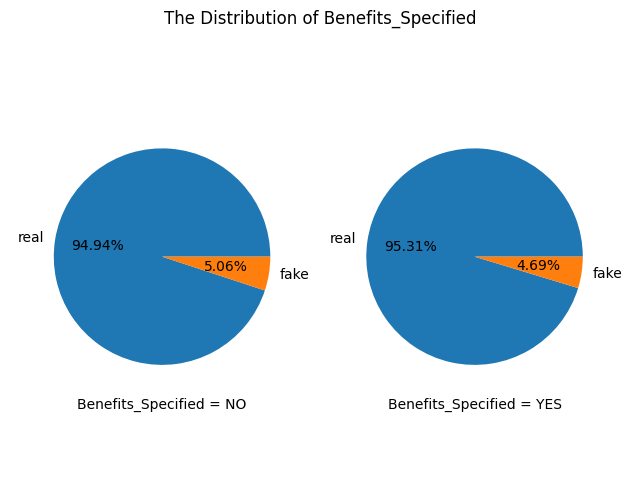

In [42]:
plt.clf()
pievs(datat,text_spec_features[3])
%matplot plt

There are big differences between the fake and real postings here. Less fake postings have company profiles and descriptions.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

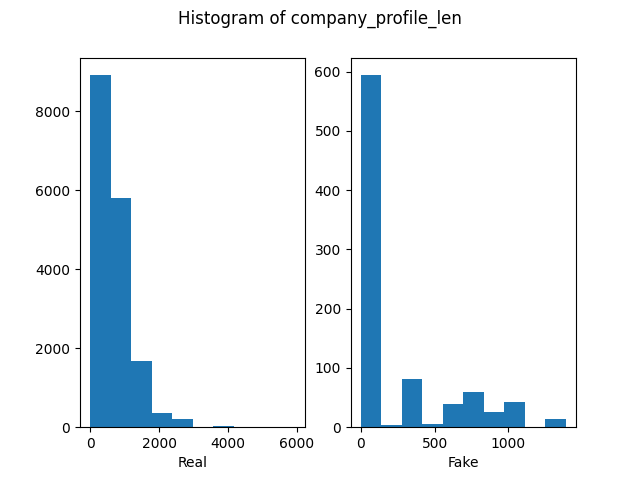

In [43]:
plt.clf()
hstvs(datat,'company_profile_len')
%matplot plt

For the feature of 'company_profile_len', most of the profiles are less than 200, but real postings have more texts than the fake ones.  And fake postings have a weird distribution.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

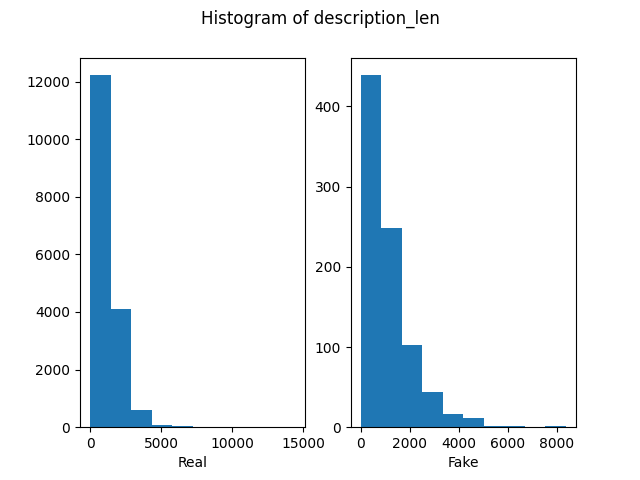

In [44]:
plt.clf()
hstvs(datat, 'description_len')
%matplot plt

Real and Fake postings have the similar patterns in 'description_len'.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

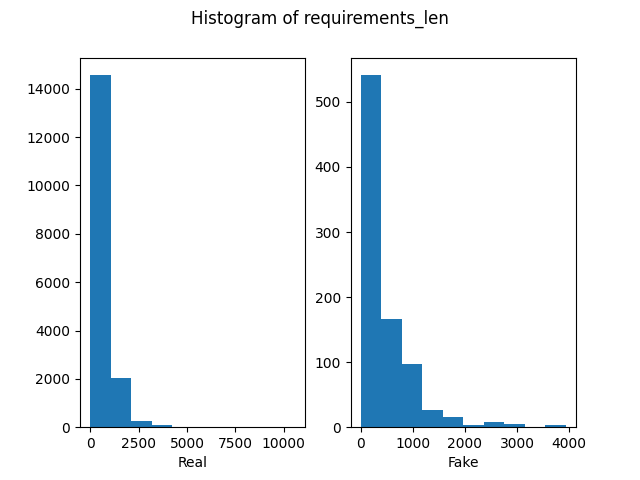

In [45]:
plt.clf()
hstvs(datat, 'requirements_len')
%matplot plt

Real and Fake postings have the similar patterns in 'benefits_len'.  The real postings have more texts.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

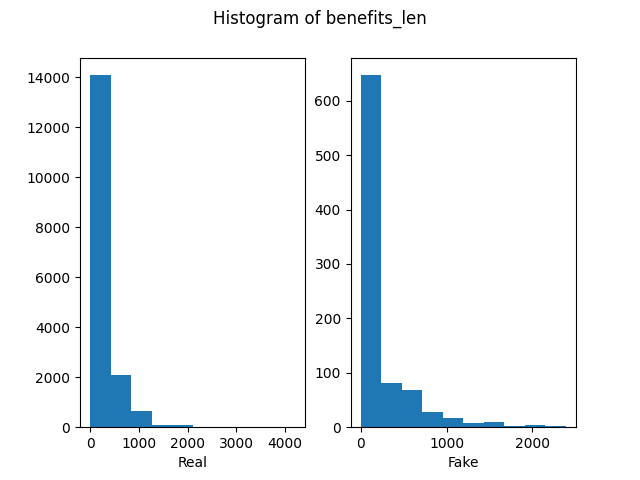

In [46]:
plt.clf()
hstvs(datat, 'benefits_len')
%matplot plt

Real and Fake postings have the similar patterns in 'benefits_len'.

**Handling outliers**

In [47]:
features = ['job_id', 'company_profile_len', 'description_len', 'requirements_len','benefits_len']
quantiles = [0.25, 0.75]

cut_off_points = []

#lets convert the pandas dataframe to spark dataframe to use spark functions
imputed_sp = datat[features].to_spark()

#getting Q1 and Q3
#The third parameter, set to 0.05, is relative target precision to achieve (>= 0).
#If set to zero, the exact quantiles are computed, which could be very expensive. 
for feature in features:
    quants = imputed_sp.approxQuantile(feature, quantiles, 0.05)
    print(feature, quants)
    IQR = quants[1] - quants[0]
    cut_off_points.append((feature, [
        quants[0] - 1.5 * IQR,
        quants[1] + 1.5 * IQR,
    ]))

cut_off_points = dict(cut_off_points)

outliers = imputed_sp.select(*['job_id'] + [
       (
           (imputed_sp[f] < cut_off_points[f][0]) |
           (imputed_sp[f] > cut_off_points[f][1])
       ).alias(f + '_o') for f in features
  ]).to_pandas_on_spark()
outliers.head(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

job_id [3634.0, 13122.0]
company_profile_len [132.0, 819.0]
description_len [568.0, 1441.0]
requirements_len [133.0, 728.0]
benefits_len [0.0, 243.0]
    job_id  job_id_o  company_profile_len_o  description_len_o  requirements_len_o  benefits_len_o
0        1     False                  False              False               False           False
1        2     False                  False              False               False            True
2        3     False                  False              False               False           False
3        4     False                  False              False               False            True
4        5     False                  False              False               False           False
5        6     False                  False               True               False           False
6        7     False                  False              False               False           False
7        8     False                  False              F

We will not delete any outliers.  Outliers might show some identities for fake posting.

**General descriptive:**

In [78]:
descriptive_stats = datat[textlen_features].describe()
descriptive_stats

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

       company_profile_len  description_len  requirements_len  benefits_len
count         17880.000000     17880.000000      17880.000000  17880.000000
mean            601.338702      1174.637808        570.589318    200.636130
std             549.449949       845.876231        594.400223    324.487495
min               0.000000         0.000000          0.000000      0.000000
25%             132.000000       584.000000        137.000000      0.000000
50%             548.000000       986.000000        449.000000     41.000000
75%             854.000000      1543.000000        795.000000    279.000000
max            5960.000000     14442.000000      10598.000000   4212.000000

**Descriptive for fake posting:**

In [79]:
descriptive_stats1 = datat[textlen_features][datat.fraudulent == True].describe()
descriptive_stats1

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

       company_profile_len  description_len  requirements_len  benefits_len
count           866.000000       866.000000        866.000000    866.000000
mean            223.205543      1117.859122        429.797921    201.524249
std             367.243957       968.094211        553.372094    354.855900
min               0.000000         0.000000          0.000000      0.000000
25%               0.000000       442.000000         45.000000      0.000000
50%               0.000000       820.000000        241.000000     34.000000
75%             404.000000      1442.000000        623.000000    247.000000
max            1388.000000      8362.000000       3934.000000   2390.000000

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

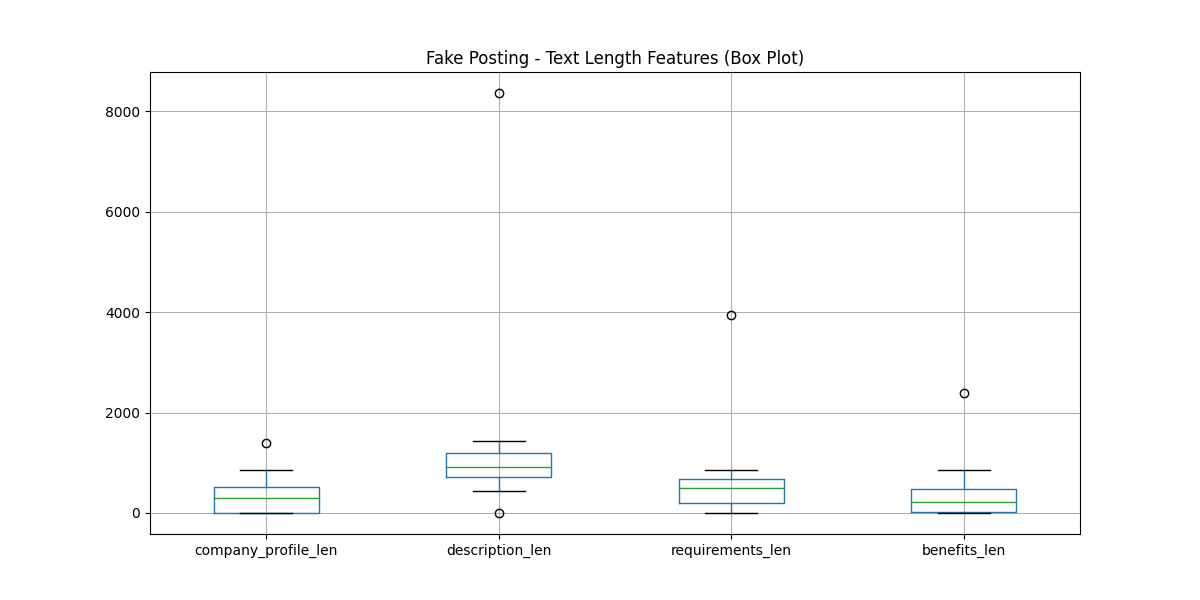

In [80]:
plt.clf()
plt.figure(figsize=(12, 6))
descriptive_stats1.to_pandas().boxplot()
plt.title('Fake Posting - Text Length Features (Box Plot)')
%matplot plt

**Descriptive for real posting**

In [81]:
descriptive_stats0 = datat[textlen_features][datat.fraudulent == False].describe()
descriptive_stats0

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

       company_profile_len  description_len  requirements_len  benefits_len
count          17014.00000     17014.000000      17014.000000  17014.000000
mean             620.58540      1177.527801        577.755495    200.590925
std              550.23316       839.109179        595.538670    322.876681
min                0.00000         4.000000          0.000000      0.000000
25%              219.00000       595.000000        143.000000      0.000000
50%              569.00000       995.000000        460.000000     43.000000
75%              858.00000      1546.000000        804.000000    281.000000
max             5960.00000     14442.000000      10598.000000   4212.000000

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

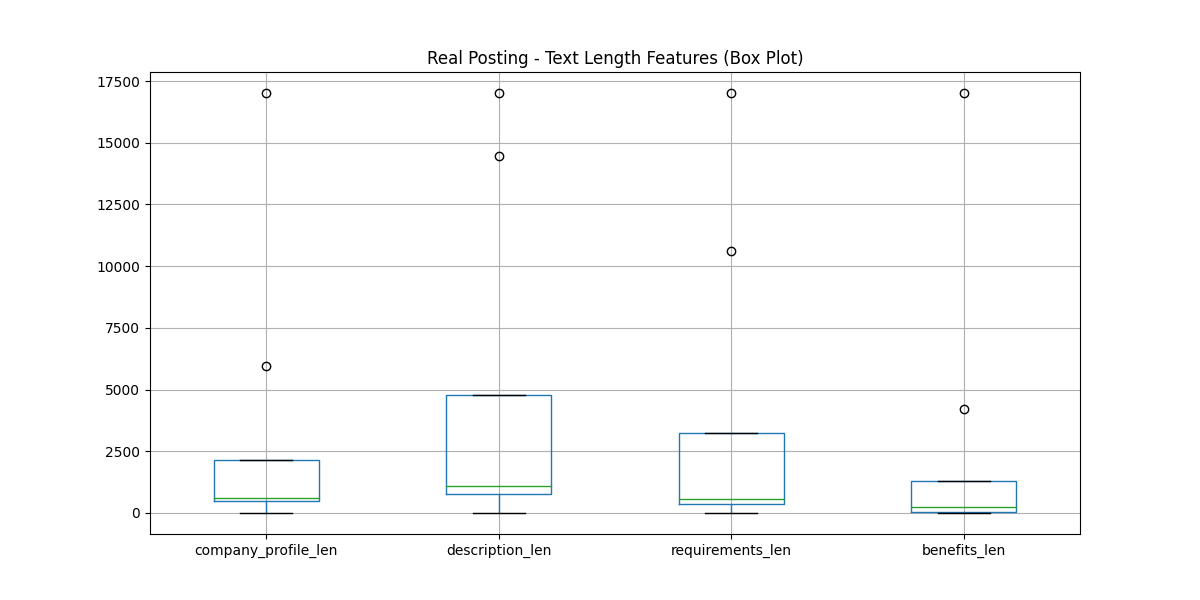

In [82]:
plt.clf()
plt.figure(figsize=(12, 6))
descriptive_stats0.to_pandas().boxplot()
plt.title('Real Posting - Text Length Features (Box Plot)')
%matplot plt

Real companies have more text informations.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

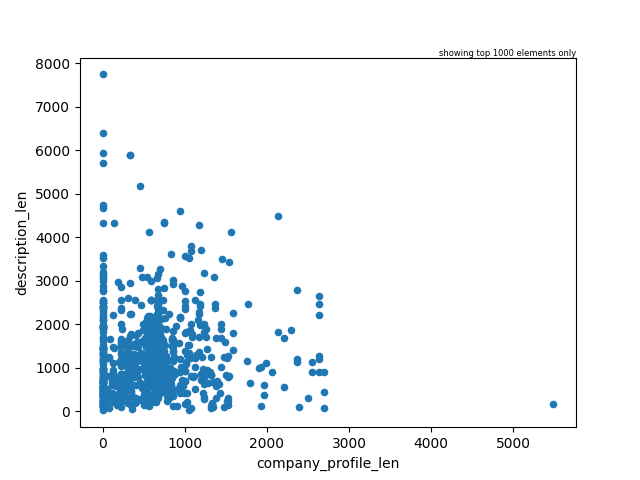

In [84]:
datan=datat.copy()
scatterplot(datan,'company_profile_len','description_len')
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

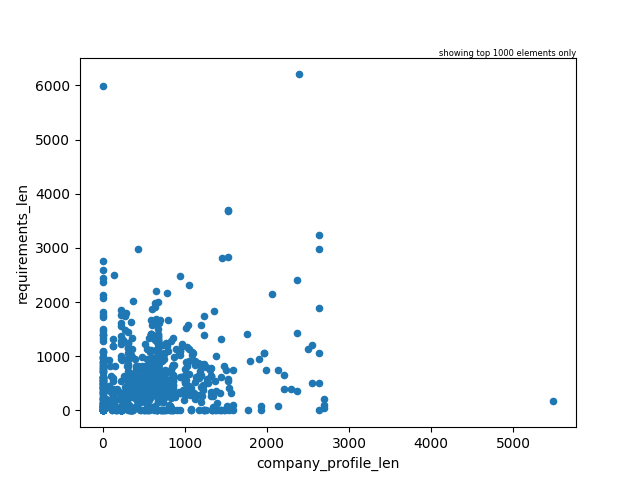

In [85]:
scatterplot(datan,'company_profile_len','requirements_len')
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

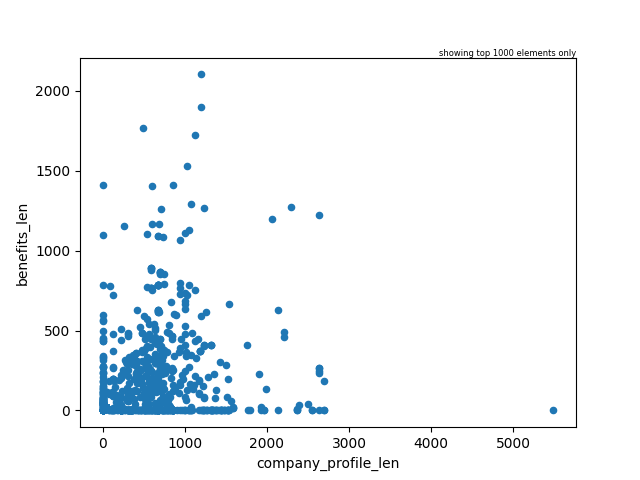

In [86]:
scatterplot(datan,'company_profile_len','benefits_len')
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

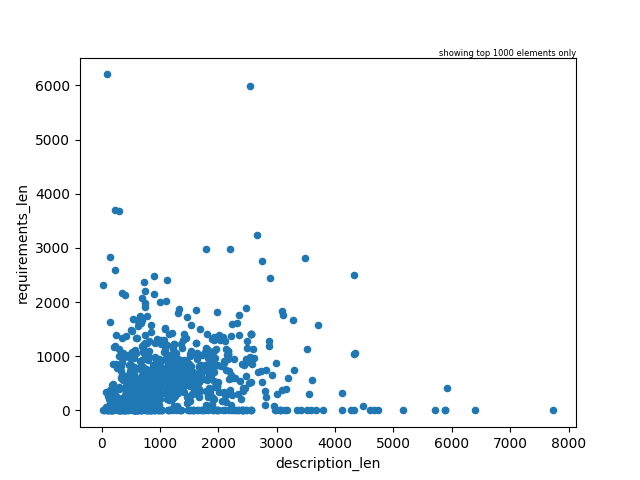

In [87]:
scatterplot(datan,'description_len','requirements_len')
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

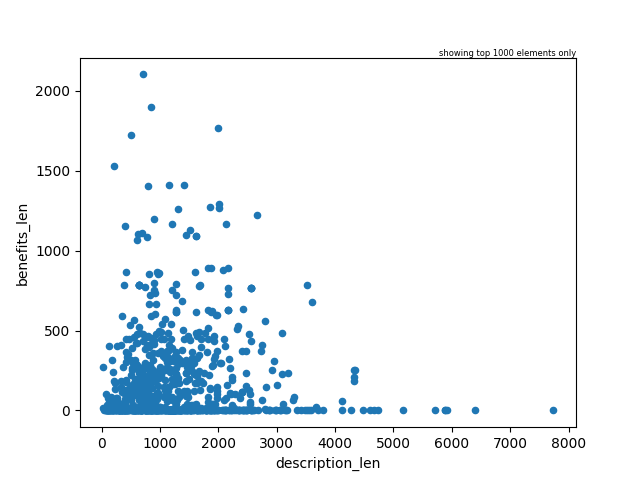

In [88]:
scatterplot(datan,'description_len','benefits_len')
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

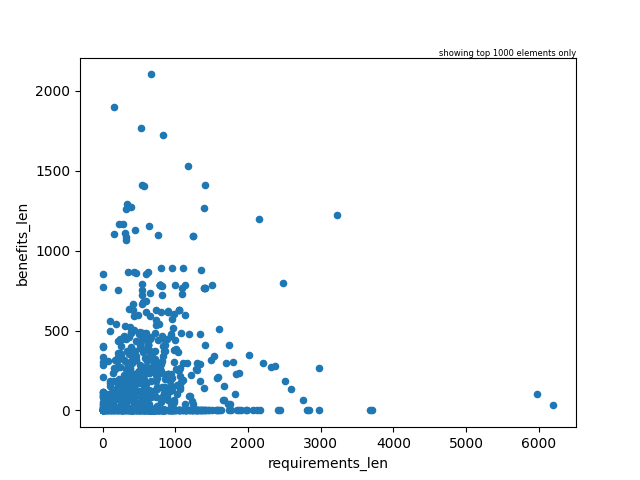

In [89]:
scatterplot(datan,'requirements_len','benefits_len')
%matplot plt

These numeric columns are related with each other and the patters are similar.

### Complex features

***Splitting `Location`***

- Filling Null values from location with 'Unspecified'
- Splitting location into 3 seperate columns: country, state, city. We will use them as a categorical features.
- Dropping location column
- Regroup location features

In [106]:
datas=data[['job_id', 'fraudulent', 'location']]
datas['location_filled']=datas['location'].fillna('Unspecified, Unspecified, Unspecified')
datas.location_filled.head(15)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0          US, NY, New York
1            NZ, , Auckland
2             US, IA, Wever
3        US, DC, Washington
4        US, FL, Fort Worth
5                  US, MD, 
6            DE, BE, Berlin
7     US, CA, San Francisco
8         US, FL, Pensacola
9           US, AZ, Phoenix
10      US, NJ, Jersey City
11          GB, LND, London
12         US, CT, Stamford
13          US, FL, Orlando
14          AU, NSW, Sydney
Name: location_filled, dtype: object

In [107]:
data2 = (datas.to_spark().rdd
         .map(lambda row: addToRow(row, 'country', row.location_filled.split(', ')[0]))
         .map(lambda row: addToRow(row, 'state', row.location_filled.split(', ')[1]))
         .map(lambda row: addToRow(row, 'city', row.location_filled.split(', ')[2]))
         .toDF()).to_pandas_on_spark()
loc_features=['country','state','city']
data2[loc_features].head() 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  country state        city
0      US    NY    New York
1      NZ          Auckland
2      US    IA       Wever
3      US    DC  Washington
4      US    FL  Fort Worth

In [108]:
data = ps.merge(data, data2[['job_id']+loc_features], on='job_id', how='left')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

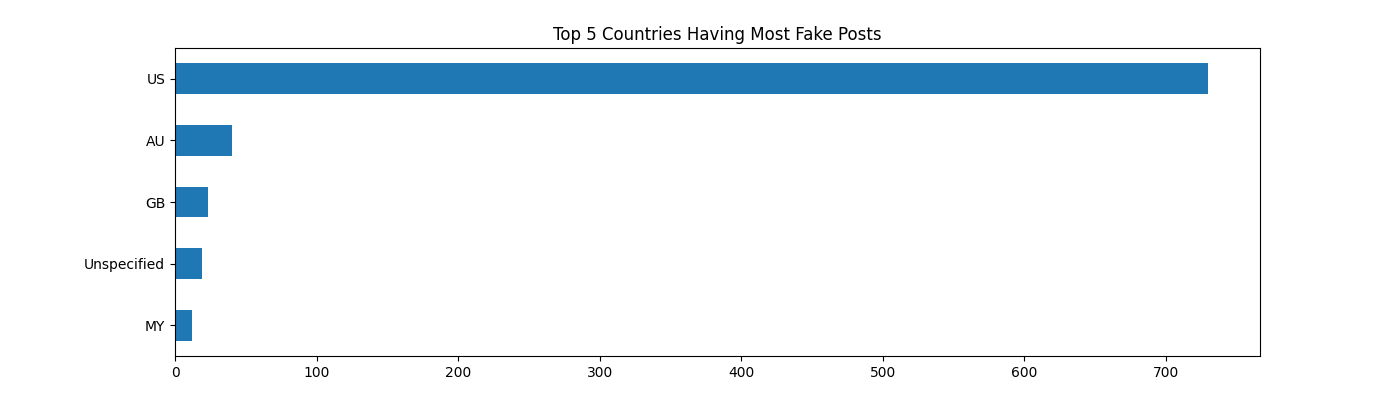

In [80]:
plt.clf()
plt.figure(figsize=(14, 4))
country = data2['country'][data2['fraudulent']==1].value_counts().sort_values(ascending=False).iloc[:5].sort_values(ascending=True).plot.barh()
plt.title('Top 5 Countries Having Most Fake Posts')
#plt.tight_layout()
%matplot plt

The US, AU, GB, some unspecified locations, and MY have the most fake posts.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

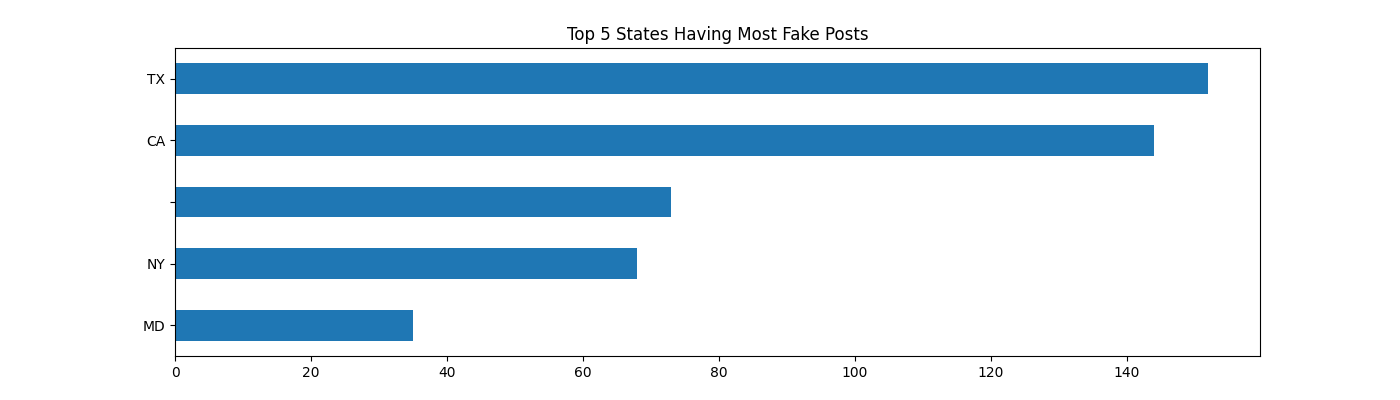

In [59]:
plt.clf()
plt.figure(figsize=(14, 4))
state = data2['state'][data2['fraudulent']==1].value_counts().sort_values(ascending=False).iloc[:5].sort_values(ascending=True).plot.barh()
plt.title('Top 5 States Having Most Fake Posts')
#plt.tight_layout()
%matplot plt

TX, CA, some unspecified states, NY and MD have the most fake posts.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

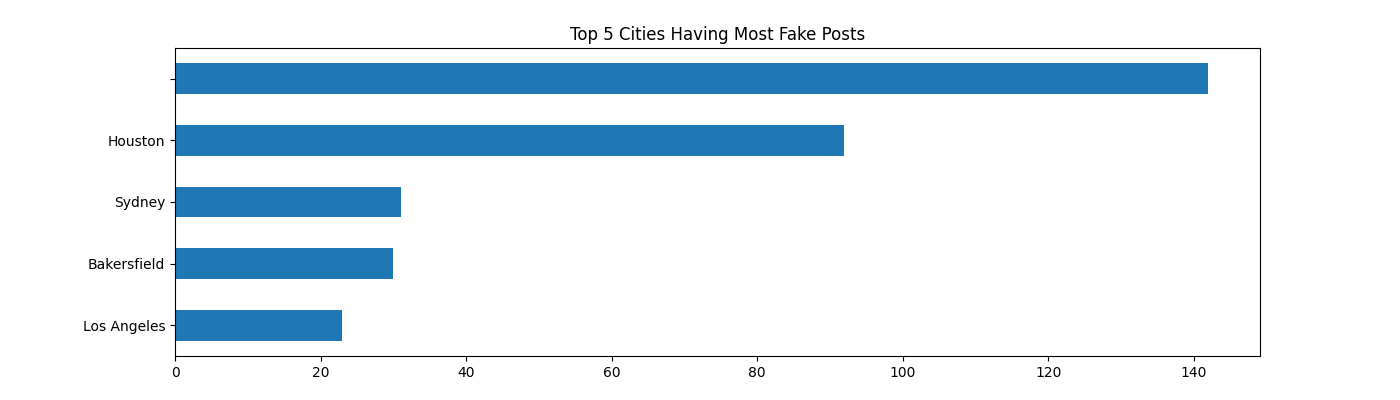

In [60]:
plt.clf()
plt.figure(figsize=(14, 4))
city = data2['city'][data2['fraudulent']==1].value_counts().sort_values(ascending=False).iloc[:5].sort_values(ascending=True).plot.barh()
plt.title('Top 5 Cities Having Most Fake Posts')
#plt.tight_layout()
%matplot plt

Some unspecified cities, Houston, Sydney, Bakerfield, and Los Angelos have the most fake posts.

***Converting `Salary_Ranges`***

More 80% 'salary_range' is missing. There are different salary types, such as hourly, weekly, biweekly and annually.  It is unnessary to split it into minium and maxium salaries. So we add a new column show the salary is specified or not, then drop salary_range.

In [134]:
datasa = data[['job_id', 'fraudulent', 'salary_range']]
# generate bool feature
datasa['salary_specified'] = datasa['salary_range'].fillna(0)
datasa['salary_specified'] = datasa.salary_specified.map(lambda x : 0 if x == '0' else 1)
#datasa['salary_specified'] = datasa.salary_specified
datasa[['salary_specified']].head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   salary_specified
0                 0
1                 0
2                 0
3                 0
4                 0

In [137]:
data = ps.merge(data, datasa[['job_id', 'salary_specified']], on='job_id', how='left')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

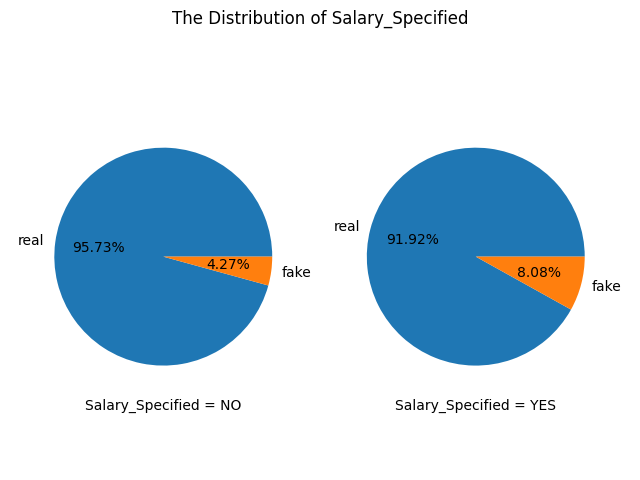

In [138]:
plt.clf()
pievs(datasa,'salary_specified')
%matplot plt

More fake companies specified the salaries.

### Categorical Features

In [143]:
datac=data[['job_id', 'fraudulent']+cat_features]
datac[cat_features].info()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 17880 entries, 0 to 17879
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   department           6325 non-null   object
 2   employment_type      14409 non-null  object
 3   required_experience  10830 non-null  object
 4   required_education   9775 non-null   object
 5   industry             12977 non-null  object
 6   function             11424 non-null  object
dtypes: object(7)

Many missing data,except `title`.  Based on the finddings on Milestone 3, we generate bool features to identify whether the infomation is specified.

In [146]:
catn=['department', 'employment_type', 'required_experience', 'required_education', 'industry', 'function']
for c in catn:
    datac['{}_specified'.format(c)] = datac[c].fillna(0)
    datac['{}_specified'.format(c)] = datac['{}_specified'.format(c)].map(lambda x : 0 if x == '0' else 1)
cat_spec_features=['{}_specified'.format(c) for c in catn]
datac[cat_features]=datac[cat_features].fillna('Unspecified')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
data = ps.merge(data, datac[['job_id']+cat_spec_features], on='job_id', how='left')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

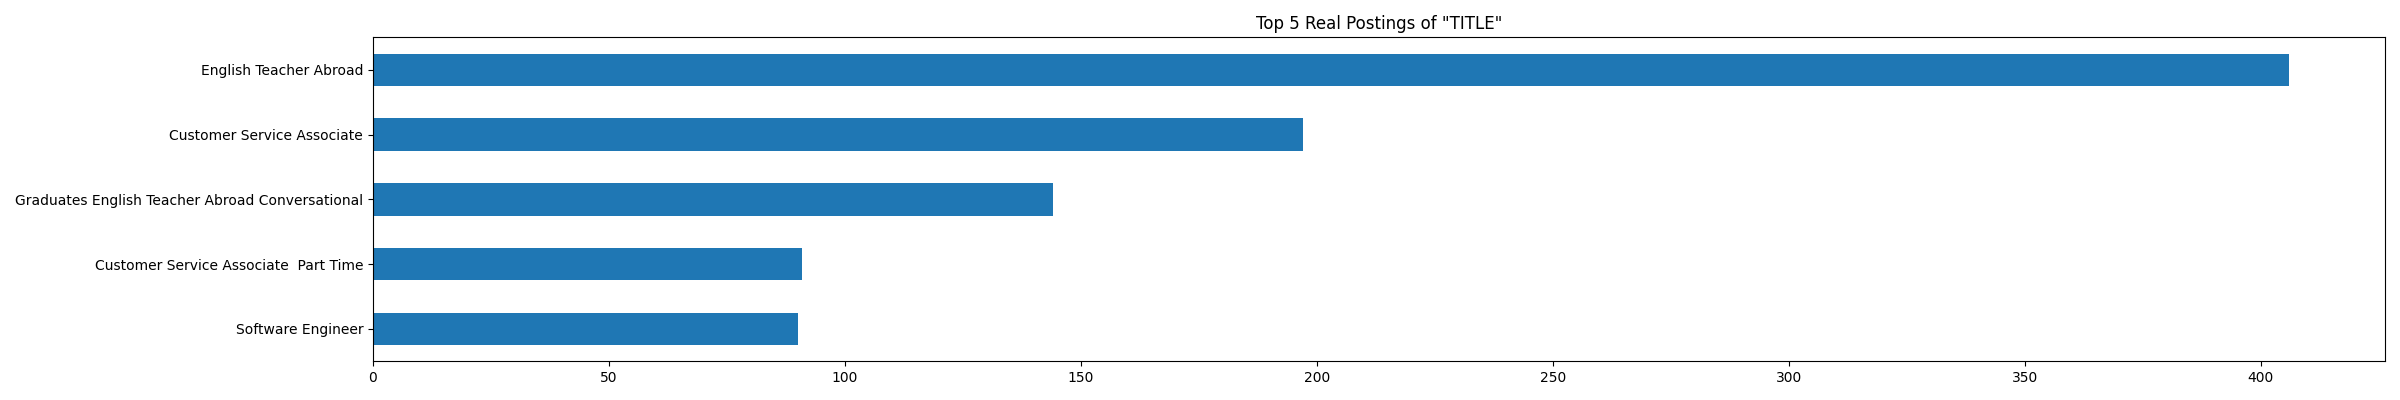

In [149]:
cleaned=datac.copy()
plt.clf()
barchart(cleaned, 'title', 0)
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

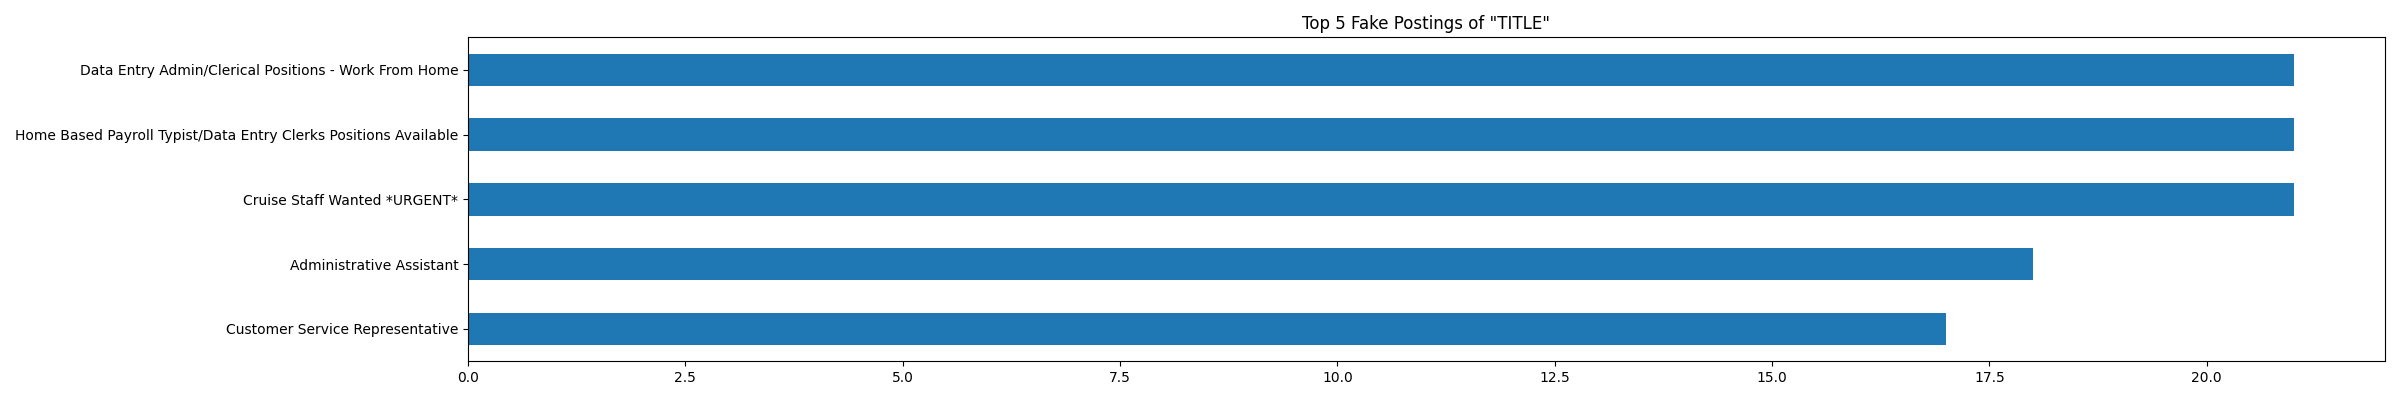

In [170]:
plt.clf()
barchart(cleaned, 'title', 1)
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

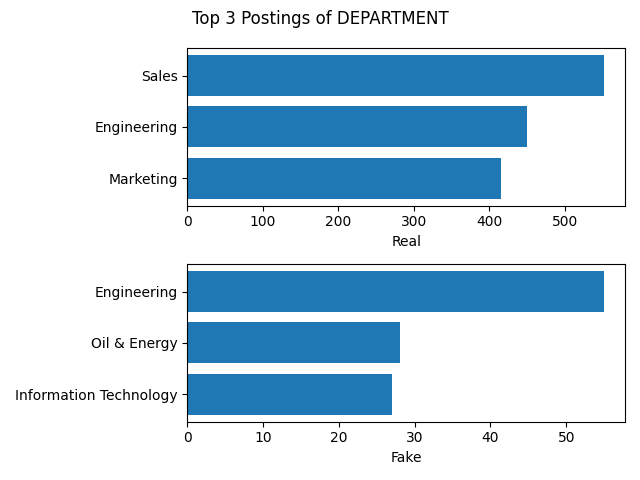

In [157]:
plt.clf()
barvs(cleaned, 'department')
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

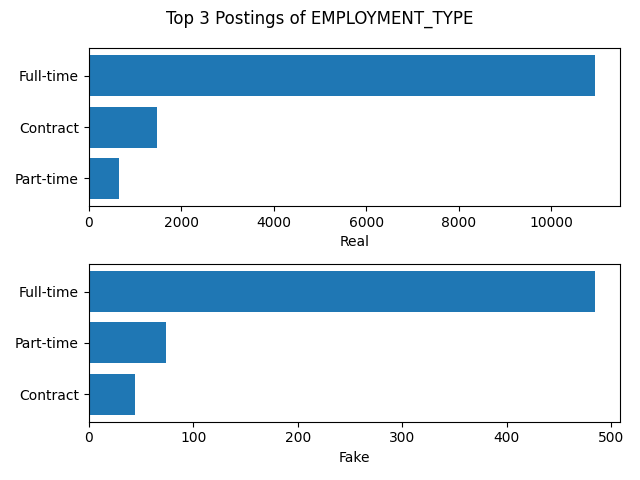

In [158]:
plt.clf()
barvs(cleaned, cat_features[2])
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

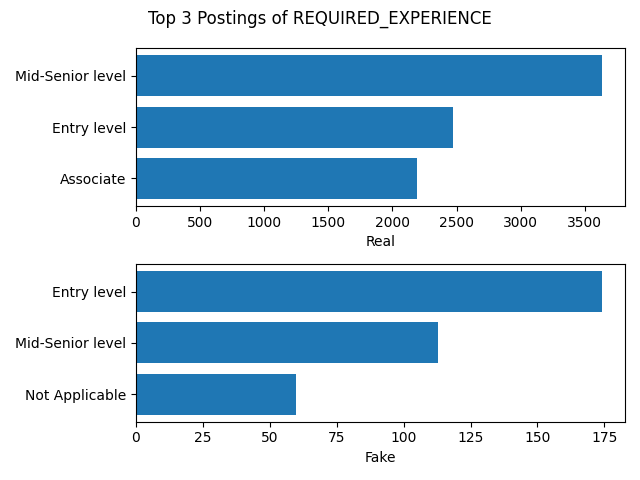

In [159]:
plt.clf()
barvs(cleaned, cat_features[3])
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

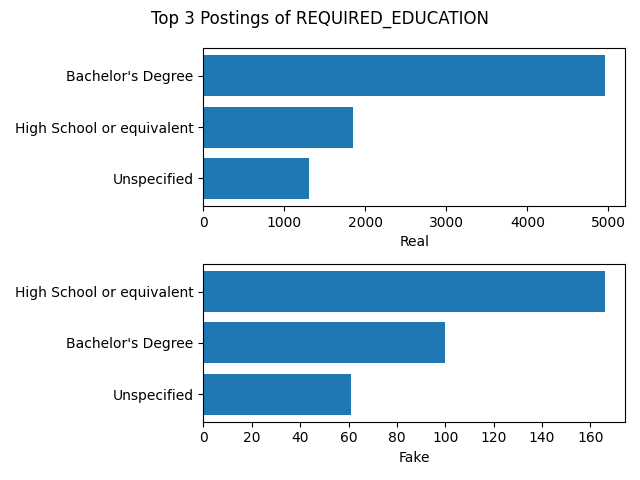

In [160]:
plt.clf()
barvs(cleaned, cat_features[4])
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

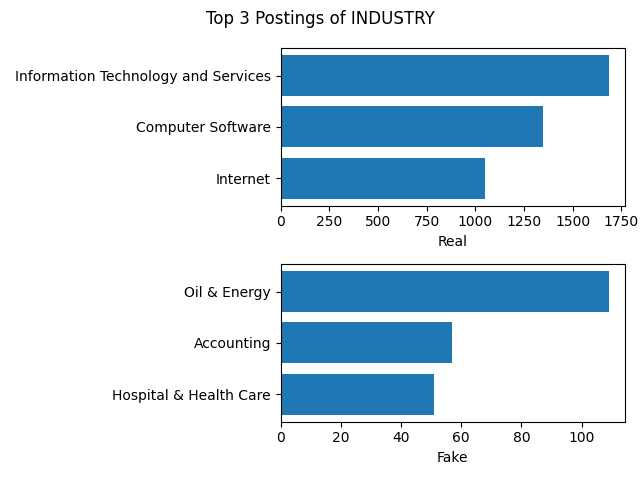

In [161]:
plt.clf()
barvs(cleaned, cat_features[5])
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

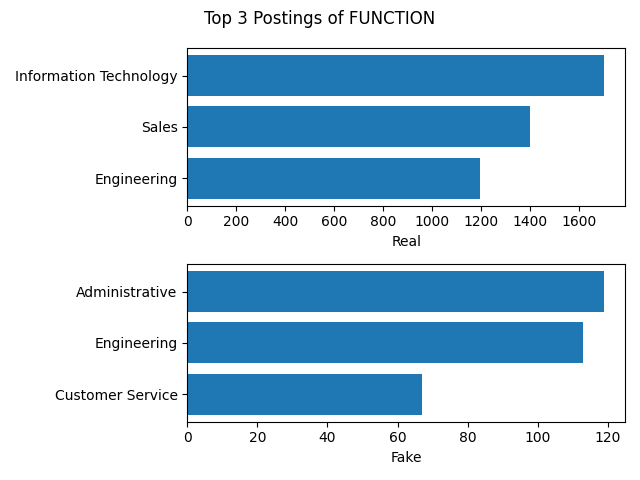

In [162]:
plt.clf()
barvs(cleaned, cat_features[6])
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

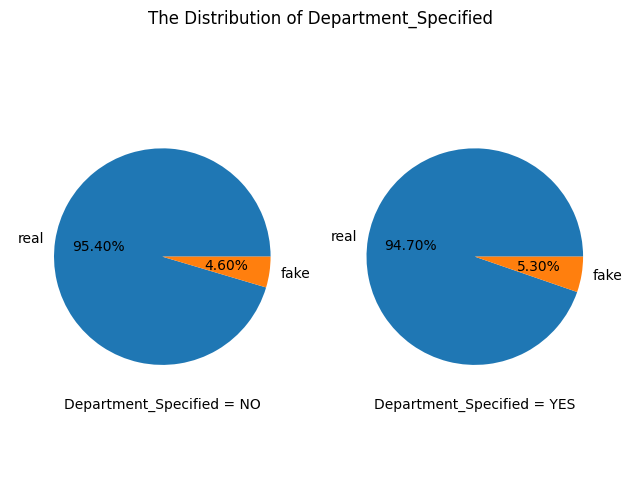

In [124]:
plt.clf()
pievs(data, cat_spec_features[0])
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

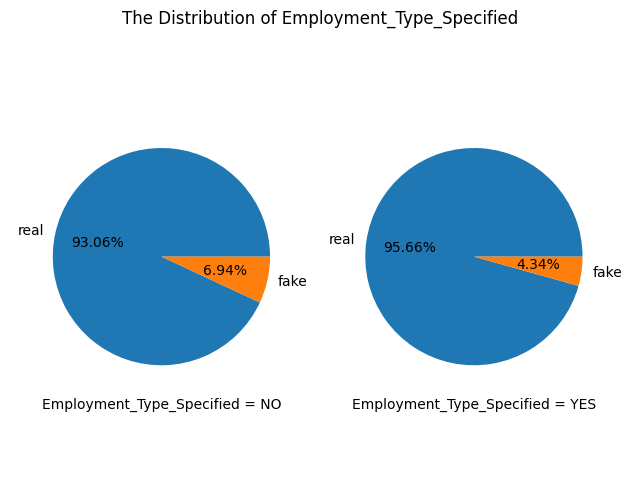

In [67]:
plt.clf()
pievs(data, cat_spec_features[1])
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

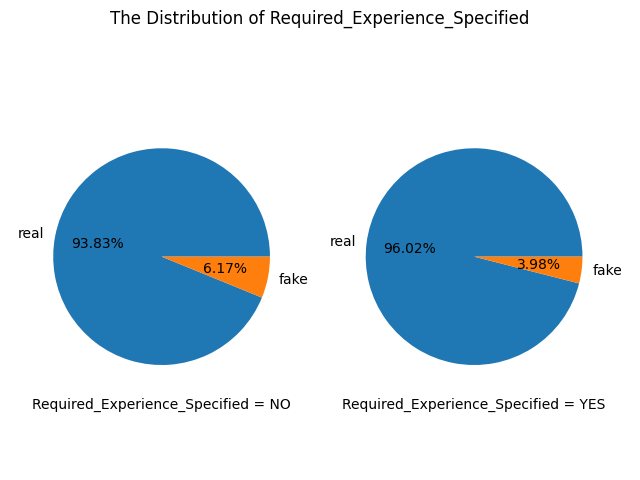

In [68]:
plt.clf()
pievs(data, cat_spec_features[2])
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

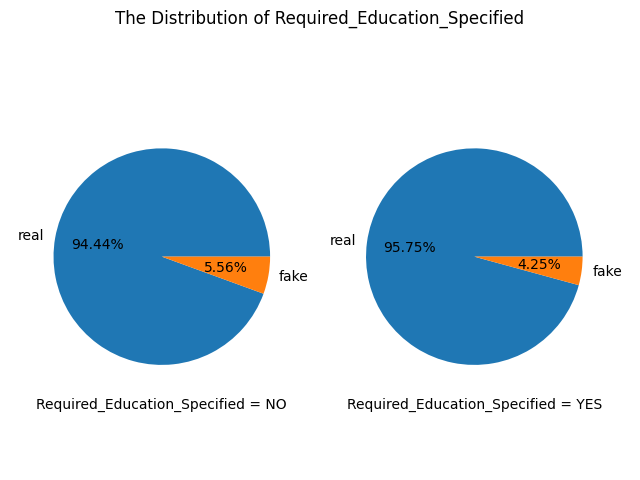

In [69]:
plt.clf()
pievs(data, cat_spec_features[3])
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

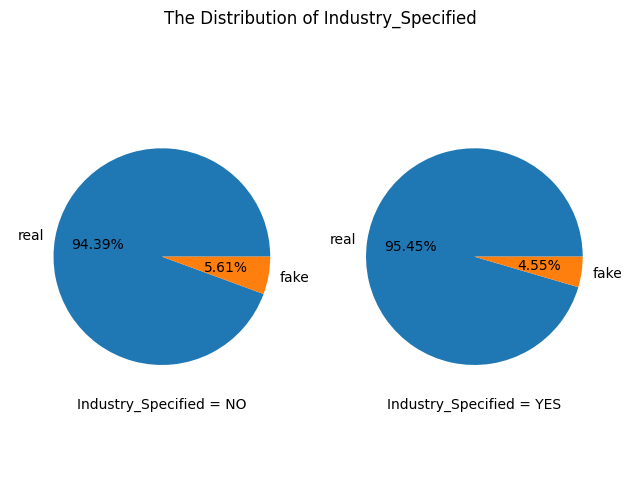

In [70]:
plt.clf()
pievs(data, cat_spec_features[4])
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

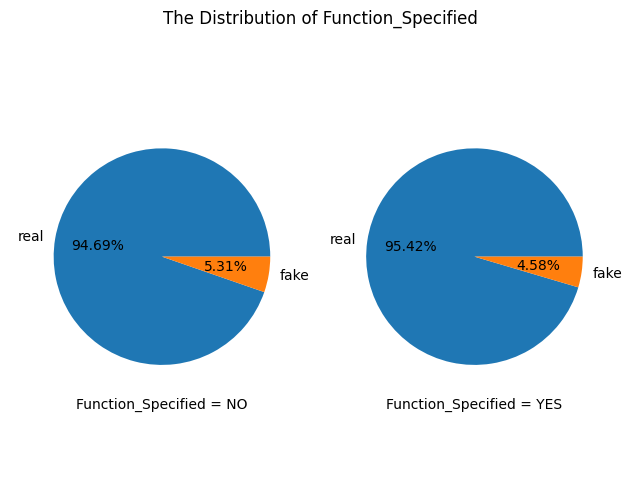

In [71]:
plt.clf()
pievs(data, cat_spec_features[5])
%matplot plt

More fake postings indicate they didn't require work experience and education.  More fake postings not specified the industry, function and employee type.

In [142]:
#save file
#data.to_spark().repartition(1).to_pandas_on_spark().to_csv('s3://gba6430-schill/project/job_postings_cleaned.csv')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Milestone 3: Modeling

### Data Modeling Plan:
1.  Correlations
2.  Data transformation
    - Binary features are ready to use
    - Numerical features have to be scaled
    - Categorical features have to be transformed into dummies
    - Text features have to be vectorized
3.  Oversampling
4.  Classification
    - Build pipelines
    - Logistic Regression
    - Random Forest
    - Tune hyperparameters

### Load cleaned data and group variables

**Variables regrouping:**

Except `job_id`, `fraudulent`, there are 32 variables in four groups.

In [12]:
data = ps.read_csv('s3://gba6430-schill/project/job_postings_cleaned.csv')
# binary features(14):
bin_features = ['telecommuting', 'has_company_logo', 'has_questions', 'salary_specified',
               'company_profile_specified', 'description_specified', 'requirements_specified', 'benefits_specified',
               'department_specified', 'employment_type_specified','required_experience_specified',
                'required_education_specified', 'industry_specified', 'function_specified']

# text features(11)
text_features = ['title', 'department', 'company_profile', 'description', 'requirements', 
                'benefits', 'industry', 'function', 'country', 'state', 'city'] 
# numeric features(4): 
num_features = ['company_profile_len', 'description_len', 'requirements_len','benefits_len']

# categorical features(3): 
cat_features = ['employment_type', 'required_experience', 'required_education']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Correlations

In [8]:
corrdata = data[bin_features + num_features]
features_and_label = feat.VectorAssembler(
    inputCols=list(corrdata.columns)
    , outputCol='features'
)

corr = st.Correlation.corr(
    features_and_label.transform(corrdata.to_spark()), 
    'features', 
    'pearson'
)

#print(str(corr.collect()[0][0]))
corr_pd = corr.toPandas()
output_np = np.array(corr_pd.iloc[0, 0].values).reshape(
    (corr_pd.iloc[0, 0].numRows, corr_pd.iloc[0, 0].numCols))

corr_pd = pd.DataFrame(output_np, columns=corrdata.columns)
corr_pd.index = corrdata.columns
corr_ps = ps.from_pandas(corr_pd)
#corr_ps.to_spark(index_col='index').repartition(1).to_pandas_on_spark().to_csv('s3://gba6430-schill/project/corr08020456')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt/yarn/usercache/livy/appcache/application_1659594020371_0002/container_1659594020371_0002_01_000001/pyspark.zip/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.

### Oversampling

In [24]:
#from pyspark.sql.functions import col, explode, array, lit
# Implement oversampling method
#import pyspark.sql.functions as F
ml_df=data.to_spark()
# calculate ratio
major_df = ml_df.filter(ml_df.fraudulent == 0)
minor_df = ml_df.filter(ml_df.fraudulent == 1)
ratio = int(major_df.count()/minor_df.count())
print("ratio: {}".format(ratio))
a = range(ratio)

# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", F.explode(F.array([F.lit(x) for x in a]))).drop('dummy')

# combine both oversampled minority rows and previous majority rows 
ml_df = major_df.unionAll(oversampled_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

ratio: 19

### Data transformation

- Categorical feastures: creates dummies for categorical features by using `pd.get_dummies()`.  I set drop_first=True.  It will help us removing redundant columns  

In [25]:
ml_ps = ml_df.to_pandas_on_spark()
df = ps.get_dummies(ml_ps, columns=cat_features, drop_first=True).to_spark()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
inp = ps.get_dummies(ml_ps[cat_features], columns=cat_features, drop_first=True).columns.to_numpy()
inp

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

array(['employment_type_Fulltime', 'employment_type_Other',
       'employment_type_Parttime', 'employment_type_Temporary',
       'employment_type_Unspecified', 'required_experience_Director',
       'required_experience_Entry level', 'required_experience_Executive',
       'required_experience_Internship',
       'required_experience_MidSenior level',
       'required_experience_Not Applicable',
       'required_experience_Unspecified',
       'required_education_Bachelors Degree',
       'required_education_Certification', 'required_education_Doctorate',
       'required_education_High School or equivalent',
       'required_education_Masters Degree',
       'required_education_Professional',
       'required_education_Some College Coursework Completed',
       'required_education_Some High School Coursework',
       'required_education_Unspecified', 'required_education_Vocational',
       'required_education_Vocational  Degree',
       'required_education_Vocational  HS Diploma'], 

In [27]:
catVect = feat.VectorAssembler(inputCols = inp, outputCol="catFeatures")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

- Numeric feastures: Use `StandardScaler` estimator to Standardizing continuous variables

In [28]:
num_in = ['company_profile_len', 'description_len', 'requirements_len', 'benefits_len']
numVect = feat.VectorAssembler(inputCols = num_in, outputCol='numFeatures')
staSca = feat.StandardScaler(inputCol = 'numFeatures', outputCol='normFeatures')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

- Text feastures (Version 1):  Use `RegexTokenizer`, `StopWordsRemover`, `CountVectorizer`, `IDF` to generate tfidf.  

In [29]:
txtVect = feat.VectorAssembler(inputCols = text_features, outputCol='txtFeatures')
# Extract tokens
txtTok= feat.RegexTokenizer(inputCol= 'txtFeatures', outputCol= 'text_words')
# Remove stop words
txtSw= feat.StopWordsRemover(inputCol= 'text_words', outputCol= 'text_sw_removed')
# Compute Term frequency
cVec = feat.CountVectorizer(inputCol="text_sw_removed", outputCol="tf_text")
# Compute Term frequency-inverse document frequency
tfIdf= feat.IDF(inputCol= 'tf_text', outputCol= 'tfidf')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

- Text feastures (Version 2):  Since we tune the parameters, text processing takes much more time than others.  So instead of pipeline, we generate tfidf at first.

# combine four text features into one
ml_df = ml_df.withColumn("text", concat(ml_df['company_profile'], ml_df['description'],ml_df['requirements'],ml_df['benefits'],
                                        ml_df['title'], ml_df['department'], ml_df['industry'], ml_df['function'], ml_df['country'], ml_df['state'], ml_df['city']))

# Remove marks
ml_df = ml_df.withColumn('text',regexp_replace(col('text'), '[^0-9A-Za-z]', ''))
# Extract tokens
text_tokenizer= RegexTokenizer(inputCol= 'text', outputCol= 'text_words',pattern= '\\W+', toLowercase= True)
ml_df = text_tokenizer.transform(ml_df)
# Remove stop words
text_sw_remover= StopWordsRemover(inputCol= 'text_words', outputCol= 'text_sw_removed')
ml_df = text_sw_remover.transform(ml_df)
# Compute Term frequency
cv = CountVectorizer(inputCol="text_sw_removed", outputCol="tf_text")
model = cv.fit(ml_df)
ml_df = model.transform(ml_df)
# Compute Term frequency-inverse document frequency
tfidf= IDF(inputCol= 'tf_text', outputCol= 'tfidf')
model = tfidf.fit(ml_df)
ml_df = model.transform(ml_df)

### Modeling

### Final Model

We put the final model before previous tries and tuning.

In [ ]:
#split into train and test sets
forest_train, forest_test = (df.randomSplit([0.7, 0.3], seed=666))

#convert all features to vector
vectorAssembler = feat.VectorAssembler(
    inputCols = bin_features + ['catFeatures', 'normFeatures'], 
    outputCol = "features")
#select top 15 predictors
selector = feat.ChiSqSelector(labelCol='fraudulent', numTopFeatures=25, outputCol='selected')

rf_obj = cl.RandomForestClassifier(
    labelCol='fraudulent'
    , featuresCol=selector.getOutputCol()
    , minInstancesPerNode=1
    , numTrees=15
    , maxDepth=20
)

pipeline = Pipeline(stages=[catVect, numVect, staSca, vectorAssembler, selector, rf_obj])

pModel = pipeline.fit(forest_train)

rf_obj_trained = (
    pModel
    .transform(forest_test)
)
results_rf = rf_obj_trained.select('fraudulent', 'probability', 'prediction')


In [39]:
m=metrics(results_rf)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

precision: 0.9508323654665118
recall: 0.9945333063373153
F1: 0.9721919841662544
accuracy: 0.9716648179893113
missed: 0.005683014102294254
AUR: 0.9717173787525775

### Conclusion
1. Random Forest performs better than Logistic regression for this project.
2. Best MaxDepth = 20
3. MinInstancesPerNode = 1
4. Precision = 0.95
5. Recall = 0.99
6. Accuracy = 0.97

### Appendex: Previous models

#### 1-1. Logistic regression (without NLP)

In [177]:
#split into train and test sets
forest_train, forest_test = (
    ml_df
    .randomSplit([0.7, 0.3], seed=666)
)

#convert all features to vector
vectorAssembler = feat.VectorAssembler(
    inputCols = ['telecommuting', 'has_company_logo', 'has_questions', 'salary_specified',
                 'idxCatFeatures', 'normFeatures'], 
    outputCol="features")



#select top 10 predictors
selector = feat.ChiSqSelector(
    labelCol='fraudulent'
    , numTopFeatures=10
    , outputCol='selected'
)

#create a multinomial regression object
#DV has 2 classes
logReg_obj = cl.LogisticRegression(
    labelCol='fraudulent'
    , featuresCol=selector.getOutputCol()
    , regParam=0.01
    , elasticNetParam=1.0
    , family='binomial'
)

#create pipeline of 1)strIdx, 2)catVect, 3)catIdx, 4)numVect, 5)staSca, 6)vector, 7)chisquare selector, 8)logistic regression
pipeline = Pipeline(
    stages=[strIdx, 
            catVect, 
            catIdx, 
            numVect, 
            staSca,
            vectorAssembler, 
            selector, 
            logReg_obj
           ])
#train the model
pModel = pipeline.fit(forest_train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [178]:
# Check out the Logistic Regression object
pModel.stages[-1]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

LogisticRegressionModel: uid=LogisticRegression_70e860954738, numClasses=2, numFeatures=10

In [179]:
# Evaluating the Logistic Regression model
import pyspark.ml.evaluation as ev

#apply the model to test set
logReg_model = (
    pModel
    .transform(ml_df)
)

results_logReg = logReg_model.select('fraudulent', 'probability', 'prediction')



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [61]:
results_logReg.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+--------------------+----------+
|fraudulent|         probability|prediction|
+----------+--------------------+----------+
|         0|[0.83096489051079...|       0.0|
|         0|[0.84647942984599...|       0.0|
|         0|[0.79948503558272...|       0.0|
|         0|[0.74183027165397...|       0.0|
|         0|[0.86568877113567...|       0.0|
|         0|[0.27521483095249...|       1.0|
|         0|[0.63466578848805...|       0.0|
|         0|[0.81680963513448...|       0.0|
|         0|[0.87118015829593...|       0.0|
|         0|[0.73456552691759...|       0.0|
|         0|[0.16515114617802...|       1.0|
|         0|[0.73348892972215...|       0.0|
|         0|[0.76892177403099...|       0.0|
|         0|[0.78835572534884...|       0.0|
|         0|[0.74430068691073...|       0.0|
|         0|[0.72846780497618...|       0.0|
|         0|[0.75533809671807...|       0.0|
|         0|[0.80890215227620...|       0.0|
|         0|[0.74084136913349...|       0.0|
|         

In [67]:
#evaluate performance of the multinomial model (7 classes)
evaluator = ev.MulticlassClassificationEvaluator(
    predictionCol='prediction'
    , labelCol='fraudulent')

(
    #F-1 score
    evaluator.evaluate(results_logReg)
    #weighted precision
    , evaluator.evaluate(
        results_logReg
        , {evaluator.metricName: 'weightedPrecision'}
    ) 
    #accuracy
    , evaluator.evaluate(
        results_logReg
        , {evaluator.metricName: 'accuracy'}
    )
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(0.7495267560099934, 0.7507175689752246, 0.7510851959831552)

In [63]:
result = results_logReg
TP = result.filter(result['prediction'] == 1).filter(result['fraudulent'] == 1).count()
FN = result.filter(result['prediction'] == 0).filter(result['fraudulent'] == 1).count()
TN = result.filter(result['prediction'] == 0).filter(result['fraudulent'] == 0).count()
FP = result.filter(result['prediction'] == 1).filter(result['fraudulent'] == 0).count()
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F1 =(2*precision*recall)/(precision+recall)
accuracy = (TP+TN)/(TP+TN+FP+FN)
print("precision:",precision)
print("recall:",recall)
print("F1:",F1)
print("accuracy:",accuracy)
missed=FN/(FN+TN)
print('missed:',missed)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

precision: 0.7459356072680905
recall: 0.6755196304849884
F1: 0.7089834873504014
accuracy: 0.7510851959831552
missed: 0.24538805807226285

In [68]:
#Print selected features from chisquare selector


print(logReg_model.schema['selected'].metadata)

#print model coefficients
#for a binomial model use coefficients instead of coefficientMatrix
print(pModel.stages[-1].coefficientMatrix.toArray())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{'ml_attr': {'attrs': {'numeric': [{'idx': 0, 'name': 'telecommuting'}, {'idx': 1, 'name': 'has_company_logo'}, {'idx': 2, 'name': 'has_questions'}, {'idx': 3, 'name': 'salary_specified'}, {'idx': 7, 'name': 'normFeatures_0'}, {'idx': 8, 'name': 'normFeatures_1'}, {'idx': 9, 'name': 'normFeatures_2'}], 'nominal': [{'ord': False, 'vals': ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0'], 'idx': 4, 'name': 'idxCatFeatures_employment_type_idx'}, {'ord': False, 'vals': ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0'], 'idx': 5, 'name': 'idxCatFeatures_required_experience_idx'}, {'ord': False, 'vals': ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0', '12.0'], 'idx': 6, 'name': 'idxCatFeatures_required_education_idx'}]}, 'num_attrs': 10}}
[[-0.03587299  0.8845094   0.05486188 -0.26807272  0.          0.01650826
  -0.08105426  0.15490139 -0.01086968  0.        ]
 [ 0.03587299 -0.8845094  -0.05486188  0.26807272  0.         -0.01650826
   0.08105426 -0.154

#### 1-2: Logistic regression (with NLP)

In [72]:
#split into train and test sets
forest_train, forest_test = (ml_df.randomSplit([0.7, 0.3], seed=666))

#convert all features to vector
vectorAssembler = feat.VectorAssembler(
    inputCols = ['telecommuting', 'has_company_logo', 'has_questions', 'salary_specified',
                 'tfidf', 'idxCatFeatures', 'normFeatures'], 
    outputCol="features")

#select top 10 predictors
selector = feat.ChiSqSelector(labelCol='fraudulent', numTopFeatures=10, outputCol='selected')

#create a binomial regression object. DV has 2 classes
logReg_obj = cl.LogisticRegression(labelCol='fraudulent', featuresCol=selector.getOutputCol()
    , regParam=0.01, elasticNetParam=1.0, family='binomial')

#create pipeline of 1)strIdx, 2)catVect, 3)catIdx, 4)numVect, 5)staSca, 6)vector, 7)chisquare selector, 8)logistic regression
pipeline = Pipeline(stages=[strIdx,catVect,catIdx,numVect,staSca,vectorAssembler,selector,logReg_obj])
#train the model
pModel = pipeline.fit(forest_train)

# Check out the Logistic Regression object
pModel.stages[-1]

# Evaluating the Logistic Regression model


#apply the model to test set
logReg_model = (
    pModel
    .transform(ml_df)
)

results_logReg = logReg_model.select('fraudulent', 'probability', 'prediction')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(0.7495267560099934, 0.7507175689752246, 0.7510851959831552)

In [89]:
metrics(results_logReg)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

precision: 0.7459356072680905
recall: 0.6755196304849884
F1: 0.7089834873504014
accuracy: 0.7510851959831552
missed: 0.24538805807226285
AUR:
(0.7459356072680905, 0.6755196304849884, 0.7089834873504014, 0.7510851959831552, 0.24538805807226285)

In [74]:
#Print selected features from chisquare selector


print(logReg_model.schema['selected'].metadata)

#print model coefficients
#for a binomial model use coefficients instead of coefficientMatrix
print(pModel.stages[-1].coefficientMatrix.toArray())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{'ml_attr': {'attrs': {'numeric': [{'idx': 0, 'name': 'telecommuting'}, {'idx': 1, 'name': 'has_company_logo'}, {'idx': 2, 'name': 'has_questions'}, {'idx': 3, 'name': 'salary_specified'}, {'idx': 7, 'name': 'normFeatures_0'}, {'idx': 8, 'name': 'normFeatures_1'}, {'idx': 9, 'name': 'normFeatures_2'}], 'nominal': [{'ord': False, 'vals': ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0'], 'idx': 4, 'name': 'idxCatFeatures_employment_type_idx'}, {'ord': False, 'vals': ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0'], 'idx': 5, 'name': 'idxCatFeatures_required_experience_idx'}, {'ord': False, 'vals': ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0', '12.0'], 'idx': 6, 'name': 'idxCatFeatures_required_education_idx'}]}, 'num_attrs': 10}}
[[-0.03587299  0.8845094   0.05486188 -0.26807272  0.          0.01650826
  -0.08105426  0.15490139 -0.01086968  0.        ]
 [ 0.03587299 -0.8845094  -0.05486188  0.26807272  0.         -0.01650826
   0.08105426 -0.154

#### 2-1 Random Forest classifier (without NLP)

In [69]:
#same as previous, this time using Random Forest
rf_obj = cl.RandomForestClassifier(
    labelCol='fraudulent'
    , featuresCol=selector.getOutputCol()
    , minInstancesPerNode=10
    , numTrees=10
)

#convert all features to vector
vectorAssembler = feat.VectorAssembler(
    inputCols = ['telecommuting', 'has_company_logo', 'has_questions', 'salary_specified',
                 'idxCatFeatures', 'normFeatures'], 
    outputCol="features")



#select top 10 predictors
selector = feat.ChiSqSelector(
    labelCol='fraudulent'
    , numTopFeatures=10
    , outputCol='selected'
)


#create pipeline of 1)strIdx, 2)catVect, 3)catIdx, 4)numVect, 5)staSca, 6)vector, 7)chisquare selector, 8)logistic regression
pipeline = Pipeline(
    stages=[strIdx, 
            catVect, 
            catIdx, 
            numVect, 
            staSca,
            vectorAssembler, 
            selector, 
            rf_obj
           ])


pModel = pipeline.fit(ml_df)

rf_obj_trained = (
    pModel
    .transform(ml_df)
)
results_rf = rf_obj_trained.select('fraudulent', 'probability', 'prediction')

evaluator = ev.MulticlassClassificationEvaluator(
    predictionCol='prediction'
    , labelCol='fraudulent')

(
    evaluator.evaluate(results_rf)
    , evaluator.evaluate(
        results_rf
        , {evaluator.metricName: 'weightedPrecision'}
    )
    , evaluator.evaluate(
        results_rf
        , {evaluator.metricName: 'accuracy'}
    )
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(0.8422549152678477, 0.845667318630591, 0.8435374149659864)

In [78]:
metrics(results_rf)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

precision: 0.8682879059898808
recall: 0.7678983833718245
F1: 0.8150134048257373
accuracy: 0.8435374149659864
missed: 0.172754619681994
(0.8682879059898808, 0.7678983833718245, 0.8150134048257373, 0.8435374149659864, 0.172754619681994)

#### 2-2 Random Forest classifier (with NLP)

In [80]:
#same as previous, this time using Random Forest
rf_obj = cl.RandomForestClassifier(labelCol='fraudulent', featuresCol=selector.getOutputCol(), minInstancesPerNode=10, numTrees=10)

#convert all features to vector
vectorAssembler = feat.VectorAssembler(
    inputCols = ['telecommuting', 'has_company_logo', 'has_questions', 'salary_specified',
                 'tfidf','idxCatFeatures', 'normFeatures'], 
    outputCol="features")
#select top 10 predictors
selector = feat.ChiSqSelector(labelCol='fraudulent', numTopFeatures=10, outputCol='selected')
#create pipeline of 1)strIdx, 2)catVect, 3)catIdx, 4)numVect, 5)staSca, 6)vector, 7)chisquare selector, 8)logistic regression
pipeline = Pipeline(stages=[strIdx, catVect, catIdx,numVect, staSca, vectorAssembler, selector, rf_obj ])
pModel = pipeline.fit(ml_df)
rf_obj_trained = (pModel.transform(ml_df))
results_rf = rf_obj_trained.select('fraudulent', 'probability', 'prediction')
m=metrics(results_rf)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

precision: 0.864643009833262
recall: 0.7297921478060047
F1: 0.7915150091972917
accuracy: 0.827437641723356
missed: 0.1952542372881356

Both LR and RF show that our NLP isn't helpful. 

#### 1-3: Logistic regression (After features adjusting)

In [240]:
#split into train and test sets
forest_train, forest_test = (ml_df.randomSplit([0.7, 0.3], seed=666))

#convert all features to vector

vectorAssembler = feat.VectorAssembler(
    inputCols = bin_features + ['idxCatFeatures', 'normFeatures'], #tfidf
    outputCol="features")

#select top 10 predictors
selector = feat.ChiSqSelector(labelCol='fraudulent', numTopFeatures=15, outputCol='selected')

#create a multinomial regression object

logReg_obj = cl.LogisticRegression(labelCol='fraudulent', featuresCol=selector.getOutputCol(), 
                                   regParam=0.05, elasticNetParam=0.8, family='binomial')

#create pipeline of 1)strIdx, 2)catVect, 3)catIdx, 4)numVect, 5)staSca, 6)vector, 7)chisquare selector, 8)logistic regression
pipeline = Pipeline(stages=[catVect, numVect, staSca, txtVect, txtTok, txtSw, cVec, tfIdf,vectorAssembler,selector,logReg_obj])
#train the model
pModel = pipeline.fit(forest_train)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

- without NLP:

In [181]:

# Check out the Logistic Regression object
pModel.stages[-1]

#apply the model to test set
logReg_model = (pModel.transform(ml_df))
results_logReg = logReg_model.select('fraudulent', 'probability', 'prediction')

#Print selected features from chisquare selector
print(logReg_model.schema['selected'].metadata)
#print model coefficients
#for a binomial model use coefficients instead of coefficientMatrix
print(pModel.stages[-1].coefficientMatrix.toArray())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{'ml_attr': {'attrs': {'numeric': [{'idx': 0, 'name': 'telecommuting'}, {'idx': 1, 'name': 'has_company_logo'}, {'idx': 2, 'name': 'has_questions'}, {'idx': 3, 'name': 'salary_specified'}, {'idx': 4, 'name': 'company_profile_specified'}, {'idx': 5, 'name': 'salary_specified'}, {'idx': 6, 'name': 'employment_type_specified'}, {'idx': 7, 'name': 'required_experience_specified'}, {'idx': 8, 'name': 'required_education_specified'}, {'idx': 12, 'name': 'normFeatures_0'}, {'idx': 13, 'name': 'normFeatures_1'}, {'idx': 14, 'name': 'normFeatures_2'}], 'nominal': [{'ord': False, 'vals': ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0'], 'idx': 9, 'name': 'idxCatFeatures_employment_type_idx'}, {'ord': False, 'vals': ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0'], 'idx': 10, 'name': 'idxCatFeatures_required_experience_idx'}, {'ord': False, 'vals': ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0', '12.0'], 'idx': 11, 'name': 'idxCatFeatures_required_educatio

In [182]:
metrics(results_logReg)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

precision: 0.8043044469783353
recall: 0.6859122401847575
F1: 0.7404054320015744
accuracy: 0.7635353173180351
missed: 0.2658983329903272
AUR: 0.7622578715911444
(0.8043044469783353, 0.6859122401847575, 0.7404054320015744, 0.7635353173180351, 0.2658983329903272, 0.7622578715911444)

- with NLP:

In [238]:

# Check out the Logistic Regression object
pModel.stages[-1]

#apply the model to test set
logReg_model = (pModel.transform(ml_df))
results_logReg = logReg_model.select('fraudulent', 'probability', 'prediction')

#Print selected features from chisquare selector
print(logReg_model.schema['selected'].metadata)
#print model coefficients
#for a binomial model use coefficients instead of coefficientMatrix
print(pModel.stages[-1].coefficientMatrix.toArray())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{'ml_attr': {'attrs': {'numeric': [{'idx': 0, 'name': 'telecommuting'}, {'idx': 1, 'name': 'has_company_logo'}, {'idx': 2, 'name': 'has_questions'}, {'idx': 3, 'name': 'salary_specified'}, {'idx': 4, 'name': 'company_profile_specified'}, {'idx': 5, 'name': 'salary_specified'}, {'idx': 6, 'name': 'employment_type_specified'}, {'idx': 7, 'name': 'required_experience_specified'}, {'idx': 8, 'name': 'required_education_specified'}, {'idx': 12, 'name': 'normFeatures_0'}, {'idx': 13, 'name': 'normFeatures_1'}, {'idx': 14, 'name': 'normFeatures_2'}], 'nominal': [{'ord': False, 'vals': ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0'], 'idx': 9, 'name': 'idxCatFeatures_employment_type_idx'}, {'ord': False, 'vals': ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0'], 'idx': 10, 'name': 'idxCatFeatures_required_experience_idx'}, {'ord': False, 'vals': ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0', '12.0'], 'idx': 11, 'name': 'idxCatFeatures_required_educatio

In [239]:
metrics(results_logReg)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

precision: 0.8041898247114151
recall: 0.6859122401847575
F1: 0.7403568617160848
accuracy: 0.7634755587426796
missed: 0.2659256972316559
AUR: 0.7621990964647779
(0.8041898247114151, 0.6859122401847575, 0.7403568617160848, 0.7634755587426796, 0.2659256972316559, 0.7621990964647779)

#### 2-3 Random Forest classifier (After features adjusting)

In [244]:
#split into train and test sets
forest_train, forest_test = (ml_df.randomSplit([0.7, 0.3], seed=666))

rf_obj = cl.RandomForestClassifier(labelCol='fraudulent', featuresCol=selector.getOutputCol(), minInstancesPerNode=10, numTrees=25)

#convert all features to vector
vectorAssembler = feat.VectorAssembler(
    inputCols = bin_features + ['idxCatFeatures', 'normFeatures'], 
    outputCol = "features")
#select top 10 predictors
selector = feat.ChiSqSelector(labelCol='fraudulent', numTopFeatures=15, outputCol='selected')
#create pipeline of 1)strIdx, 2)catVect, 3)catIdx, 4)numVect, 5)staSca, 6)vector, 7)chisquare selector, 8)logistic regression
pipeline = Pipeline(stages=[catVect, numVect, staSca, vectorAssembler, selector, rf_obj])
pModel = pipeline.fit(ml_df)
rf_obj_trained = (pModel.transform(ml_df))
results_rf = rf_obj_trained.select('fraudulent', 'probability', 'prediction')
m=metrics(results_rf)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

precision: 0.8672147319960539
recall: 0.8013856812933026
F1: 0.8330016740895164
accuracy: 0.8420282060475678
missed: 0.1789410283086021
AUR: 0.8413593505796477

#### Tune Parameters

Tune hyperparameters for both models (regParam, elasticNetParam, ChiSqSelector, numTopFeatures, minInstancesPerNode)

#### Grid search
- Grid search allows us to test different values for hyper parameters, such as learning rate, regularization parameter, and elestic net parameter, and select the best values. Running the following cell will take several minutes.
- Use divide and conquer to find the best values for hyperparameters. Start with something like this: [0, 0.25, 0.5, .75, 1]
- Assuming that the best value is 0.75, you need to narrow down your search to [0.5, 1] range like this: [0.5, .6, .7, .8, .9, 1]
- Assuming that the best value from previous step is 0.6, you should further narrow down the scope to [0.5, 0.7] range using the following: [.5, .54, .58, .62, .66, .7]

#### Grid Search for Regularization Parameters

In [250]:

forest_train, forest_test = (ml_df.randomSplit([0.7, 0.3], seed=666))
vectorAssembler = feat.VectorAssembler(
    inputCols = bin_features + ['idxCatFeatures', 'normFeatures'],
    outputCol="features")

selector = feat.ChiSqSelector(labelCol='fraudulent', numTopFeatures=15, outputCol='selected')

logReg_obj = cl.LogisticRegression(labelCol='fraudulent', featuresCol=selector.getOutputCol(), family='binomial')


#use ParamGridBuilder to build a grid of parameters
logReg_grid = (
    tune.ParamGridBuilder()
    #try 4 values for regParam
    .addGrid(logReg_obj.regParam
            , [0.0, .33, 0.66, 1.0]
        )
    #try 4 values for elasticNetParam
#     .addGrid(logReg_obj.elasticNetParam
#             , [0.0, .33, 0.66, 1.0]
#         )
    .build()
)

logReg_ev = ev.MulticlassClassificationEvaluator(
    predictionCol='prediction'
    , labelCol='fraudulent')

# use K-fold cross validation for grid search
# CrossValidator binds all of these together
# default value is k=3
cross_v = tune.CrossValidator(
    estimator=logReg_obj
    , estimatorParamMaps=logReg_grid
    , evaluator=logReg_ev
)

pipeline = Pipeline(stages=[catVect, numVect, staSca, txtVect, txtTok, txtSw, cVec, tfIdf,vectorAssembler, selector])
data_trans = pipeline.fit(forest_train)

logReg_modelTest = cross_v.fit(data_trans.transform(forest_train))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [251]:
print('Best params - regParam: {}, elasticNetParam: {}'.format(
    logReg_modelTest.bestModel._java_obj.getRegParam(),
      logReg_modelTest.bestModel._java_obj.getElasticNetParam()))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Best params - regParam: 0.0, elasticNetParam: 0.0

In [252]:
# measure performance of best model
data_trans_test = data_trans.transform(forest_test)
results = logReg_modelTest.transform(data_trans_test)

print(logReg_ev.evaluate(results, {logReg_ev.metricName: 'weightedPrecision'}))
print(logReg_ev.evaluate(results, {logReg_ev.metricName: 'weightedRecall'}))
print(logReg_ev.evaluate(results, {logReg_ev.metricName: 'accuracy'}))
print('Best params - regParam: {}, elasticNetParam: {}'.format(
    logReg_modelTest.bestModel._java_obj.getRegParam(),
      logReg_modelTest.bestModel._java_obj.getElasticNetParam()))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.7696825234867024
0.7668730335938293
0.7668730335938293
Best params - regParam: 0.0, elasticNetParam: 0.0

In [253]:
#print selected features from chisquare selector
print(results.schema['selected'].metadata)

#get coefficients for the best model
logReg_modelTest.bestModel.coefficientMatrix.toArray()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{'ml_attr': {'attrs': {'numeric': [{'idx': 0, 'name': 'telecommuting'}, {'idx': 1, 'name': 'has_company_logo'}, {'idx': 2, 'name': 'has_questions'}, {'idx': 3, 'name': 'salary_specified'}, {'idx': 4, 'name': 'company_profile_specified'}, {'idx': 5, 'name': 'salary_specified'}, {'idx': 6, 'name': 'employment_type_specified'}, {'idx': 7, 'name': 'required_experience_specified'}, {'idx': 8, 'name': 'required_education_specified'}, {'idx': 12, 'name': 'normFeatures_0'}, {'idx': 13, 'name': 'normFeatures_1'}, {'idx': 14, 'name': 'normFeatures_2'}], 'nominal': [{'ord': False, 'vals': ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0'], 'idx': 9, 'name': 'idxCatFeatures_employment_type_idx'}, {'ord': False, 'vals': ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0'], 'idx': 10, 'name': 'idxCatFeatures_required_experience_idx'}, {'ord': False, 'vals': ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0', '12.0'], 'idx': 11, 'name': 'idxCatFeatures_required_educatio

In [254]:
logReg_modelTest.bestModel.extractParamMap()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{Param(parent='LogisticRegression_a462d47f0aed', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2, Param(parent='LogisticRegression_a462d47f0aed', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LogisticRegression_a462d47f0aed', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'): 'binomial', Param(parent='LogisticRegression_a462d47f0aed', name='featuresCol', doc='features column name.'): 'selected', Param(parent='LogisticRegression_a462d47f0aed', name='fitIntercept', doc='whether to fit an intercept term.'): True, Param(parent='LogisticRegression_a462d47f0aed', name='labelCol', doc='label column name.'): 'fraudulent', Param(parent='LogisticRegression_a462d47f0aed', name='maxBlockSizeInMB', doc='maximum memory in MB fo

In [256]:
trainingSummary = logReg_modelTest.bestModel.summary
# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)

# for multiclass, we can inspect metrics on a per-label basis
print("False positive rate by label:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("True positive rate by label:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("Precision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("Recall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

print("F-measure by label:")
for i, f in enumerate(trainingSummary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))
    
accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

objectiveHistory:
0.6929599168533299
0.5647202331274086
0.5313767418625733
0.5259287043800521
0.5235550181321674
0.5209165892404279
0.5202263507947814
0.5197499318544795
0.5196583080190648
0.5196097769883634
0.5196038274903554
0.5196023403969523
0.5196020052142125
0.5196019782313899
0.5196019698088455
0.5196019671986628
0.5196019664376643
0.5196019656269073
0.5196019653222201
0.5196019652341299
0.5196019652254805
False positive rate by label:
label 0: 0.28508506779514636
label 1: 0.1817048853439681
True positive rate by label:
label 0: 0.8182951146560319
label 1: 0.7149149322048536
Precision by label:
label 0: 0.7489733840304182
label 1: 0.7910176779741998
Recall by label:
label 0: 0.8182951146560319
label 1: 0.7149149322048536
F-measure by label:
label 0: 0.782101167315175
label 1: 0.7510433678098348
Accuracy: 0.7676053355917849
FPR: 0.23439528873089932
TPR: 0.7676053355917849
F-measure: 0.766872784487636
Precision: 0.769588708170797
Recall: 0.7676053355917849

#### Grid Search for Random Forest

In [ ]:
rf_obj = cl.RandomForestClassifier(
    labelCol='fraudulent'
    , featuresCol=selector.getOutputCol()
    , minInstancesPerNode=1
    , numTrees=15
)


#use ParamGridBuilder to build a grid of parameters
logReg_grid = (
    tune.ParamGridBuilder()
    #try 4 values for minInstancesPerNode
    .addGrid(rf_obj.minInstancesPerNode
            , [1, 4, 8, 12]  # 5 won in [5, 20, 40, 60] 
        )
    #try 4 values for maxDepth
    .addGrid(rf_obj.maxDepth
            , [9, 12, 15, 20]  # 10 won in [4, 6, 8, 10]
        )
    .build()
)

logReg_ev = ev.MulticlassClassificationEvaluator(
    predictionCol='prediction'
    , labelCol='fraudulent')

# use K-fold cross validation for grid search
# CrossValidator binds all of these together
# default value is k=3
cross_v = tune.CrossValidator(
    estimator=rf_obj
    , estimatorParamMaps=logReg_grid
    , evaluator=logReg_ev
)

pipeline = Pipeline(stages=[catVect, numVect, staSca, vectorAssembler, selector])
data_trans = pipeline.fit(forest_train)

logReg_modelTest = cross_v.fit(
    data_trans.transform(forest_train)
)

In [ ]:
train_v = tune.TrainValidationSplit(
    estimator=rf_obj # rf performs better 
    , estimatorParamMaps=logReg_grid
    , evaluator=logReg_ev
    #, parallelism=4
)

logReg_modelTrainV = (
    train_v
    .fit(data_trans.transform(forest_train)))

results = logReg_modelTrainV.transform(data_trans_test)

print(logReg_ev.evaluate(results, {logReg_ev.metricName: 'weightedPrecision'}))
print(logReg_ev.evaluate(results, {logReg_ev.metricName: 'weightedRecall'}))
print(logReg_ev.evaluate(results, {logReg_ev.metricName: 'accuracy'}))
print('Best params - MaxDepth: {}, MinInstancesPerNode: {}'.format(
    logReg_modelTest.bestModel._java_obj.getMaxDepth(),
      logReg_modelTest.bestModel._java_obj.getMinInstancesPerNode()))

In [258]:
print('Best params - MaxDepth: {}, MinInstancesPerNode: {}'.format(
    logReg_modelTest.bestModel._java_obj.getMaxDepth(),
      logReg_modelTest.bestModel._java_obj.getMinInstancesPerNode()))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Best params - MaxDepth: 20, MinInstancesPerNode: 1

In [261]:
logReg_modelTest.bestModel.extractParamMap()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{Param(parent='RandomForestClassifier_091b30b2fcb2', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'): True, Param(parent='RandomForestClassifier_091b30b2fcb2', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False, Param(parent='RandomForestClassifier_091b30b2fcb2', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10, Param(parent='RandomForestClassifier_091b30b2fcb2', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Support

In [262]:
trainingSummary = logReg_modelTest.bestModel.summary
# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)

# for multiclass, we can inspect metrics on a per-label basis
print("False positive rate by label:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("True positive rate by label:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("Precision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("Recall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

print("F-measure by label:")
for i, f in enumerate(trainingSummary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))
    
accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

objectiveHistory:
0.0
False positive rate by label:
label 0: 0.03791346402970896
label 1: 0.06646726487205051
True positive rate by label:
label 0: 0.9335327351279494
label 1: 0.962086535970291
Precision by label:
label 0: 0.9623982869379015
label 1: 0.932998324958124
Recall by label:
label 0: 0.9335327351279494
label 1: 0.962086535970291
F-measure by label:
label 0: 0.9477457720045548
label 1: 0.947319188741018
Accuracy: 0.9475333474486555
FPR: 0.05191407635041498
TPR: 0.9475333474486556
F-measure: 0.947536608015205
Precision: 0.9479827815487911
Recall: 0.9475333474486556

#### Train-validation splitting
Instead of using k-fold cross validation, we also can use a train-validation split approach. 

In [263]:
train_v = tune.TrainValidationSplit(
    estimator=rf_obj # rf performs better 
    , estimatorParamMaps=logReg_grid
    , evaluator=logReg_ev
    #, parallelism=4
)

logReg_modelTrainV = (
    train_v
    .fit(data_trans.transform(forest_train)))

results = logReg_modelTrainV.transform(data_trans_test)

print(logReg_ev.evaluate(results, {logReg_ev.metricName: 'weightedPrecision'}))
print(logReg_ev.evaluate(results, {logReg_ev.metricName: 'weightedRecall'}))
print(logReg_ev.evaluate(results, {logReg_ev.metricName: 'accuracy'}))
print('Best params - MaxDepth: {}, MinInstancesPerNode: {}'.format(
    logReg_modelTest.bestModel._java_obj.getMaxDepth(),
      logReg_modelTest.bestModel._java_obj.getMinInstancesPerNode()))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.9510084967172756
0.9507764132751446
0.9507764132751446
Best params - MaxDepth: 10, MinInstancesPerNode: 5

In [ ]:
Final Model has been moved to the first one 